In [1]:
"TRƯỚC KHI FINE TURNING"

'TRƯỚC KHI FINE TURNING'

Found 962 files belonging to 4 classes.
Using 770 files for training.
Found 962 files belonging to 4 classes.
Using 192 files for validation.
Đang tải mô hình: MobileNetV1
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
MobileNetV1 - Loss: 0.5486, Accuracy: 0.8125, Precision: 0.5429, Recall: 0.5574, F1 Score: 0.5468
Đang tải mô hình: MobileNetV2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
MobileNetV2 - Loss: 0.4480, Accuracy: 0.8750, Precision: 0.5365, Recall: 0.5599, F1 Score: 0.5466
Đang tải mô hình: MobileNetV3_Small
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step 
MobileNetV3_Small - Loss: 0.6664, Accuracy: 0.7656, Precision: 0.5129, Recall: 0.4589, F1 Score: 0.4718
Đang tải mô hình: MobileNetV3_Large
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
MobileNetV3_Large - Loss: 0.3452, Accuracy: 0.9219, Precision: 0.6543, Recall: 0.6188, F1 Score: 0.6326
Đang tải mô hình: EfficientNetB0
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
EfficientNetB0 - Loss: 0.6323, Accuracy: 0.7031, Precision: 0.3439, Recall: 0.3801, F1 Score: 0

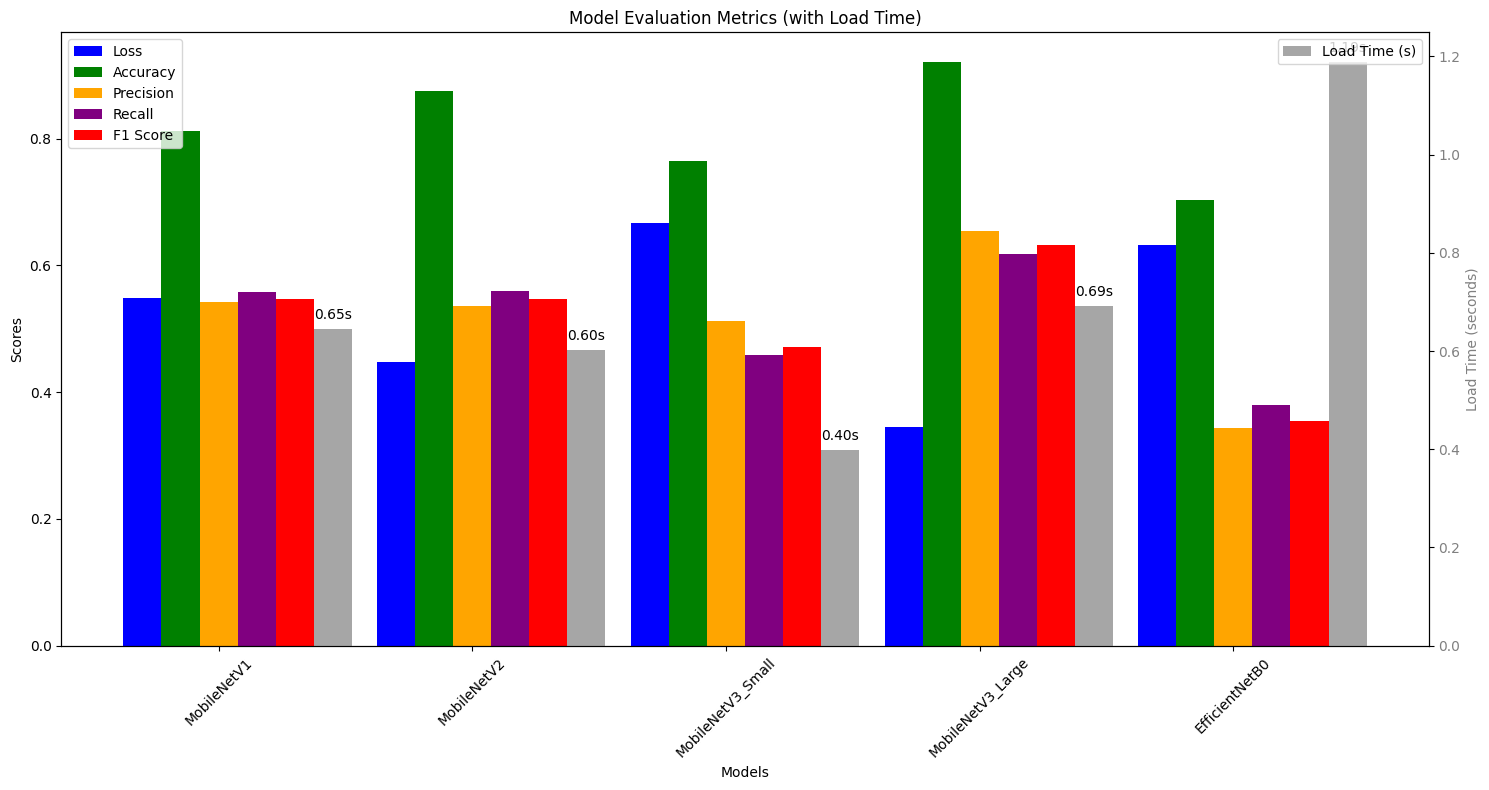

In [5]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf

# ===========================
# Thiết lập Tập Dữ Liệu
# ===========================

# Đường dẫn tới dataset
DATASET_DIR = 'dataset'  # Thay đổi đường dẫn này cho phù hợp
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tạo test dataset từ validation dataset (20% dữ liệu)
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(max(1, val_batches // 5))
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# ===========================
# Thiết lập Mô Hình và Đánh Giá
# ===========================

# Danh sách file checkpoint và tên mô hình tương ứng
model_files = {
    "MobileNetV1": "D:\\AnacondaPython\\NCKH\\KhongFineTurning\\mobileNet_V1_FE.keras",
    "MobileNetV2": "D:\\AnacondaPython\\NCKH\\KhongFineTurning\\mobileNet_V2_FE.keras",
    "MobileNetV3_Small": "D:\\AnacondaPython\\NCKH\\KhongFineTurning\\mobileNet_V3_Small_FE.keras",
    "MobileNetV3_Large": "D:\\AnacondaPython\\NCKH\\KhongFineTurning\\mobileNet_V3_Large_FE.keras",
    "EfficientNetB0": "D:\\AnacondaPython\\NCKH\\KhongFineTurning\\EfficientNet_B0_FE.keras"
}

# Lưu kết quả đánh giá
results = []

# Duyệt qua từng mô hình và đánh giá
for model_name, file_path in model_files.items():
    print(f"Đang tải mô hình: {model_name}")
    start_time = time.time()
    
    try:
        # Kiểm tra sự tồn tại của file checkpoint
        if not os.path.exists(file_path):
            print(f"Checkpoint file not found: {file_path}")
            continue

        # Tải mô hình
        model = load_model(file_path)
        load_time = time.time() - start_time  # Tính thời gian tải mô hình

        # Đánh giá mô hình trên tập test
        loss, accuracy = model.evaluate(test_dataset, verbose=0)
        
        # Lấy toàn bộ dữ liệu từ test_dataset để dự đoán
        all_predictions, all_labels = [], []
        for image_batch, label_batch in test_dataset:
            predictions_probs = model.predict(image_batch)
            predictions = np.argmax(predictions_probs, axis=1)
            labels = np.argmax(label_batch.numpy(), axis=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels)
        
        # Tính Precision, Recall, và F1-Score
        precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

        # Lưu kết quả
        results.append({
            'model_name': model_name,
            'load_time': load_time,
            'loss': loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

        print(f"{model_name} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    except Exception as e:
        print(f"Lỗi khi tải {model_name}: {e}")

# ===========================
# Vẽ Biểu Đồ Tổng Hợp
# ===========================

# Tách thông tin từ kết quả
model_names = [res['model_name'] for res in results]
losses = [res['loss'] for res in results]
accuracies = [res['accuracy'] for res in results]
precisions = [res['precision'] for res in results]
recalls = [res['recall'] for res in results]
f1_scores = [res['f1_score'] for res in results]
load_times = [res['load_time'] for res in results]

# Thiết lập biểu đồ
x = np.arange(len(model_names))
width = 0.15  # Độ rộng của từng cột

plt.figure(figsize=(15, 8))

# Vẽ các chỉ số
plt.bar(x - 2*width, losses, width, label='Loss', color='blue')
plt.bar(x - width, accuracies, width, label='Accuracy', color='green')
plt.bar(x, precisions, width, label='Precision', color='orange')
plt.bar(x + width, recalls, width, label='Recall', color='purple')
plt.bar(x + 2*width, f1_scores, width, label='F1 Score', color='red')

# Vẽ cột thời gian tải mô hình
ax1 = plt.gca()  # Lấy trục chính
ax2 = ax1.twinx()  # Tạo trục Y phụ
ax2.bar(x + 3*width, load_times, width, label='Load Time (s)', color='gray', alpha=0.7)
ax2.set_ylabel('Load Time (seconds)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Thêm chú thích cho thời gian tải
for i in range(len(load_times)):
    ax2.text(x[i] + 3*width, load_times[i] + 0.02, f"{load_times[i]:.2f}s", ha='center', color='black', fontsize=10)

# Thiết lập nhãn
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.set_xlabel('Models')
ax1.set_ylabel('Scores')
ax1.set_title('Model Evaluation Metrics (with Load Time)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
SAU KHI FINETURNING

Found 962 files belonging to 4 classes.
Using 770 files for training.
Found 962 files belonging to 4 classes.
Using 192 files for validation.
Checkpoint: checkpoint_FT\mobileNet_V1_finetuned_final.keras
Loss: 0.2751
Accuracy: 0.9062
Precision: 0.8794
Recall: 0.8315
F1 Score: 0.8330
Time: 2.0852 seconds
----------------------------------------
Checkpoint: checkpoint_FT\mobileNet_V2_finetuned_final.keras
Loss: 0.2294
Accuracy: 0.9219
Precision: 0.8374
Recall: 0.8381
F1 Score: 0.8351
Time: 2.8086 seconds
----------------------------------------
Checkpoint: checkpoint_FT\mobileNet_V3_Small_finetuned_final.keras
Loss: 0.4422
Accuracy: 0.8594
Precision: 0.8798
Recall: 0.7366
F1 Score: 0.7510
Time: 1.9659 seconds
----------------------------------------
Checkpoint: checkpoint_FT\mobileNet_V3_Large_finetuned_final.keras
Loss: 0.1706
Accuracy: 0.9688
Precision: 0.9643
Recall: 0.8271
F1 Score: 0.8531
Time: 2.8014 seconds
----------------------------------------
Checkpoint: checkpoint_FT\Efficien

D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


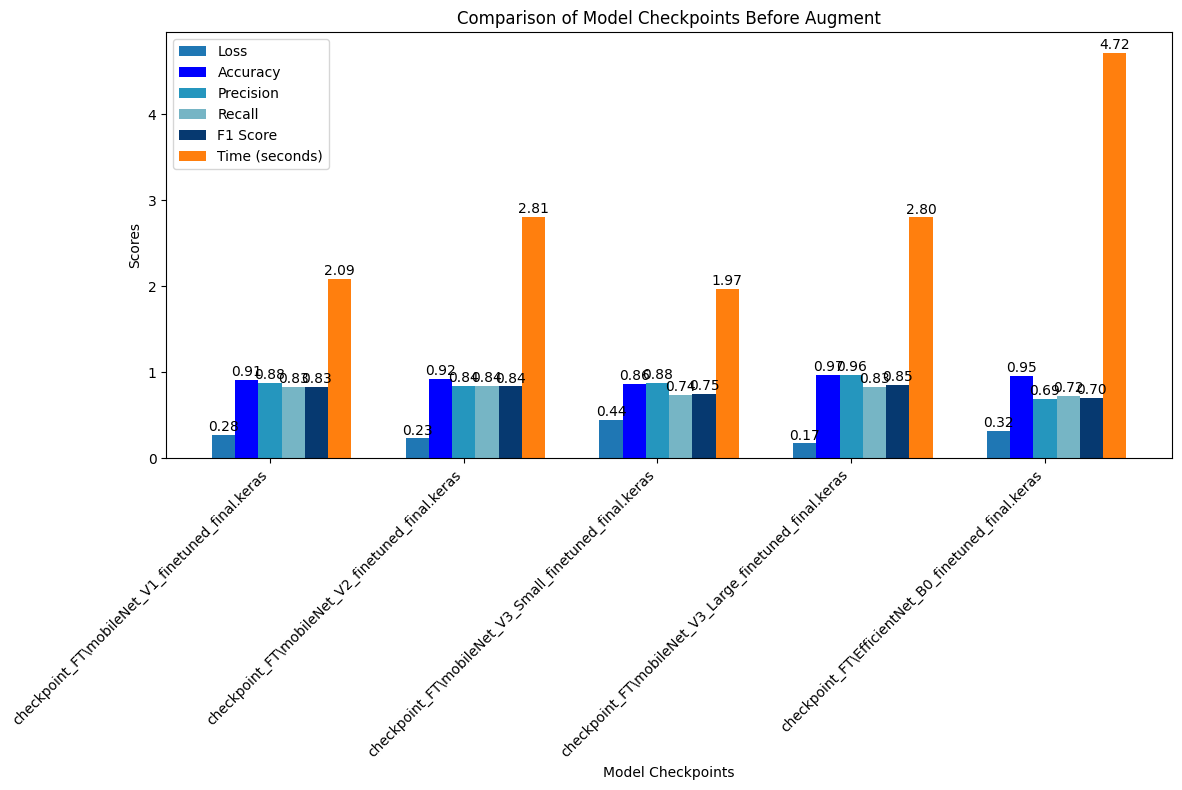

In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
import time  # Import module time để đo thời gian

# Đường dẫn tới các checkpoint mô hình
checkpoint_files = [
    'checkpoint_FT\mobileNet_V1_finetuned_final.keras',
    'checkpoint_FT\mobileNet_V2_finetuned_final.keras',
    'checkpoint_FT\mobileNet_V3_Small_finetuned_final.keras',
    'checkpoint_FT\mobileNet_V3_Large_finetuned_final.keras',
    'checkpoint_FT\EfficientNet_B0_finetuned_final.keras'
]

# Đường dẫn tới dataset
DATASET_DIR = 'dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",    
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="validation",   
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tính số batch trong validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Tạo test dataset từ validation dataset (lấy 20% dữ liệu)
test_dataset = validation_dataset.take(max(1, val_batches // 5))

# Cập nhật lại validation_dataset bằng cách bỏ qua phần đã lấy cho test
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Danh sách lưu kết quả
results = []

# Đánh giá mô hình trên tập test
for checkpoint_file in checkpoint_files:
    start_time = time.time()  # Đo thời gian bắt đầu
    
    # Load mô hình
    model = load_model(checkpoint_file)

    # Đánh giá mô hình trên test dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Lấy batch ảnh và nhãn để dự đoán
    image_batch, label_batch = next(iter(test_dataset))
    predictions_probs = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions_probs, axis=1)
    labels = np.argmax(label_batch, axis=1)

    # Tính toán các chỉ số
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # Đo thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time  # Tính thời gian

    # Lưu kết quả
    results.append({
        'checkpoint': checkpoint_file,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'time': elapsed_time  # Lưu thời gian
    })

    # In kết quả đánh giá cho từng checkpoint
    print(f"Checkpoint: {checkpoint_file}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Time: {elapsed_time:.4f} seconds")
    print("-" * 40)

# Vẽ biểu đồ so sánh
model_names = [result['checkpoint'] for result in results]
losses = [result['loss'] for result in results]
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
f1_scores = [result['f1_score'] for result in results]
times = [result['time'] for result in results]  # Thêm thời gian vào danh sách

x = np.arange(len(model_names))  # Vị trí của các cột
width = 0.12  # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(12, 8))

# Vẽ các cột cho từng chỉ số
bar1 = ax.bar(x - 2 * width, losses, width, label='Loss', color='#1f77b4')
bar2 = ax.bar(x - width, accuracies, width, label='Accuracy', color='blue')
bar3 = ax.bar(x, precisions, width, label='Precision', color='#2596be')
bar4 = ax.bar(x + width, recalls, width, label='Recall', color='#76b5c5')
bar5 = ax.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='#063970')
bar6 = ax.bar(x + 3 * width, times, width, label='Time (seconds)', color='#ff7f0e')  # Thêm cột thời gian

# Gắn tên các mô hình vào trục x
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")

# Thêm tiêu đề và nhãn
ax.set_xlabel("Model Checkpoints")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Checkpoints Before Augment")
ax.legend()

# Hiển thị giá trị trên mỗi cột
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)
add_labels(bar5)
add_labels(bar6)  # Hiển thị giá trị cho cột thời gian

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [ ]:
AUG không fine turning

Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Checkpoint: Checkpoit_FE_Aug\mobileNet_V1_FE_Aug.keras
Loss: 0.1993
Accuracy: 0.9308
Precision: 0.8607
Recall: 0.8718
F1 Score: 0.8630
Time: 4.2264 seconds
----------------------------------------
Checkpoint: Checkpoit_FE_Aug\mobileNet_V2_FE_Aug.keras
Loss: 0.1523
Accuracy: 0.9576
Precision: 0.9615
Recall: 0.9286
F1 Score: 0.9375
Time: 5.3951 seconds
----------------------------------------
Checkpoint: Checkpoit_FE_Aug\mobileNet_V3_Small_FE_Aug.keras
Loss: 0.1989
Accuracy: 0.9464
Precision: 0.9487
Recall: 0.8750
F1 Score: 0.8988
Time: 3.0987 seconds
----------------------------------------
Checkpoint: Checkpoit_FE_Aug\mobileNet_V3_Large_FE_Aug.keras
Loss: 0.1411
Accuracy: 0.9554
Precision: 0.9545
Recall: 0.9116
F1 Score: 0.9224
Time: 5.7156 seconds
----------------------------------------
Checkpoint: Checkpoit_FE_Aug\efficientNet_B0_Aug.ker

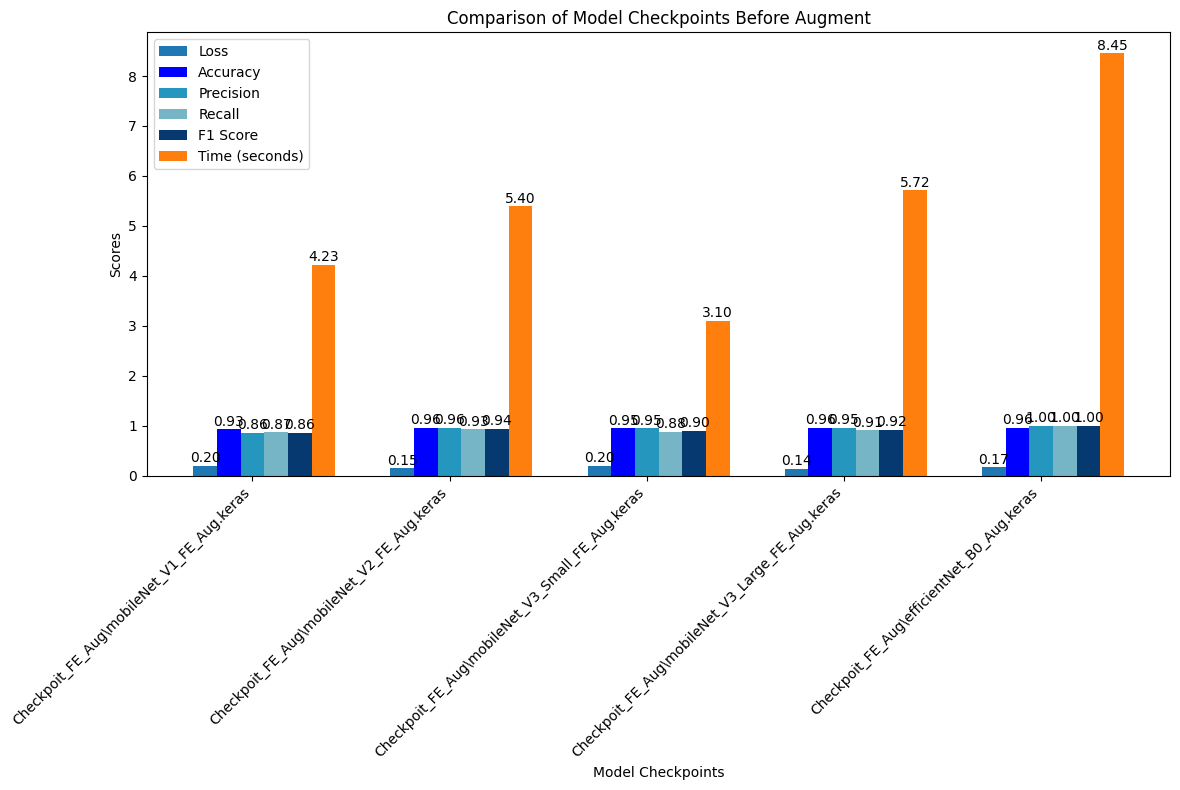

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
import time  # Import module time để đo thời gian

# Đường dẫn tới các checkpoint mô hình
checkpoint_files = [
    'Checkpoit_FE_Aug\mobileNet_V1_FE_Aug.keras',
    'Checkpoit_FE_Aug\mobileNet_V2_FE_Aug.keras',
    'Checkpoit_FE_Aug\mobileNet_V3_Small_FE_Aug.keras',
    'Checkpoit_FE_Aug\mobileNet_V3_Large_FE_Aug.keras',
    'Checkpoit_FE_Aug\efficientNet_B0_Aug.keras'
]

# Đường dẫn tới dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",    
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="validation",   
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tính số batch trong validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Tạo test dataset từ validation dataset (lấy 20% dữ liệu)
test_dataset = validation_dataset.take(max(1, val_batches // 5))

# Cập nhật lại validation_dataset bằng cách bỏ qua phần đã lấy cho test
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Danh sách lưu kết quả
results = []

# Đánh giá mô hình trên tập test
for checkpoint_file in checkpoint_files:
    start_time = time.time()  # Đo thời gian bắt đầu
    
    # Load mô hình
    model = load_model(checkpoint_file)

    # Đánh giá mô hình trên test dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Lấy batch ảnh và nhãn để dự đoán
    image_batch, label_batch = next(iter(test_dataset))
    predictions_probs = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions_probs, axis=1)
    labels = np.argmax(label_batch, axis=1)

    # Tính toán các chỉ số
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # Đo thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time  # Tính thời gian

    # Lưu kết quả
    results.append({
        'checkpoint': checkpoint_file,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'time': elapsed_time  # Lưu thời gian
    })

    # In kết quả đánh giá cho từng checkpoint
    print(f"Checkpoint: {checkpoint_file}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Time: {elapsed_time:.4f} seconds")
    print("-" * 40)

# Vẽ biểu đồ so sánh
model_names = [result['checkpoint'] for result in results]
losses = [result['loss'] for result in results]
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
f1_scores = [result['f1_score'] for result in results]
times = [result['time'] for result in results]  # Thêm thời gian vào danh sách

x = np.arange(len(model_names))  # Vị trí của các cột
width = 0.12  # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(12, 8))

# Vẽ các cột cho từng chỉ số
bar1 = ax.bar(x - 2 * width, losses, width, label='Loss', color='#1f77b4')
bar2 = ax.bar(x - width, accuracies, width, label='Accuracy', color='blue')
bar3 = ax.bar(x, precisions, width, label='Precision', color='#2596be')
bar4 = ax.bar(x + width, recalls, width, label='Recall', color='#76b5c5')
bar5 = ax.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='#063970')
bar6 = ax.bar(x + 3 * width, times, width, label='Time (seconds)', color='#ff7f0e')  # Thêm cột thời gian

# Gắn tên các mô hình vào trục x
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")

# Thêm tiêu đề và nhãn
ax.set_xlabel("Model Checkpoints")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Checkpoints Before Augment")
ax.legend()

# Hiển thị giá trị trên mỗi cột
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)
add_labels(bar5)
add_labels(bar6)  # Hiển thị giá trị cho cột thời gian

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [ ]:
SAU KHI TANG CUONG

Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Checkpoint: Checkpoint_FT_Aug\mobileNet_V1_finetuned_aug.keras
Loss: 0.0909
Accuracy: 0.9665
Precision: 0.8758
Recall: 0.8782
F1 Score: 0.8741
Time: 4.0550 seconds
----------------------------------------
Checkpoint: Checkpoint_FT_Aug\MobileNet_V2_finetuned_final_Aug.keras
Loss: 0.0433
Accuracy: 0.9955
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Time: 47.1035 seconds
----------------------------------------
Checkpoint: Checkpoint_FT_Aug\mobileNet_V3_Small_finetuned_final_Aug.keras
Loss: 0.1263
Accuracy: 0.9665
Precision: 0.9487
Recall: 0.8750
F1 Score: 0.8988
Time: 2.1699 seconds
----------------------------------------
Checkpoint: Checkpoint_FT_Aug\mobileNet_V3_Large_finetuned_final_Aug.keras
Loss: 0.0046
Accuracy: 0.9978
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Time: 4.3023 seconds
----------------------------------------
C

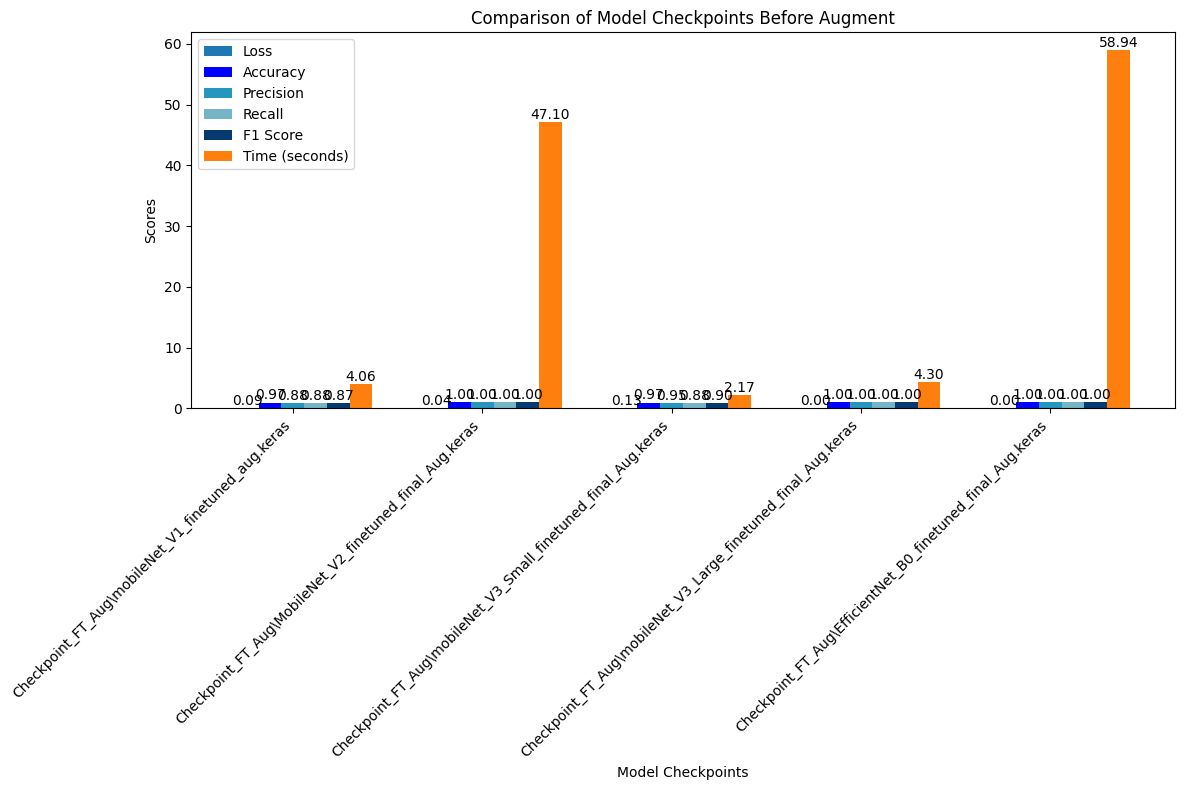

In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
import time  # Import module time để đo thời gian

# Đường dẫn tới các checkpoint mô hình
checkpoint_files = [
    'Checkpoint_FT_Aug\mobileNet_V1_finetuned_aug.keras',
    'Checkpoint_FT_Aug\MobileNet_V2_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug\mobileNet_V3_Small_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug\mobileNet_V3_Large_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug\EfficientNet_B0_finetuned_final_Aug.keras'
]

# Đường dẫn tới dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",    
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="validation",   
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tính số batch trong validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Tạo test dataset từ validation dataset (lấy 20% dữ liệu)
test_dataset = validation_dataset.take(max(1, val_batches // 5))

# Cập nhật lại validation_dataset bằng cách bỏ qua phần đã lấy cho test
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Danh sách lưu kết quả
results = []

# Đánh giá mô hình trên tập test
for checkpoint_file in checkpoint_files:
    start_time = time.time()  # Đo thời gian bắt đầu
    
    # Load mô hình
    model = load_model(checkpoint_file)

    # Đánh giá mô hình trên test dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Lấy batch ảnh và nhãn để dự đoán
    image_batch, label_batch = next(iter(test_dataset))
    predictions_probs = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions_probs, axis=1)
    labels = np.argmax(label_batch, axis=1)

    # Tính toán các chỉ số
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # Đo thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time  # Tính thời gian

    # Lưu kết quả
    results.append({
        'checkpoint': checkpoint_file,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'time': elapsed_time  # Lưu thời gian
    })

    # In kết quả đánh giá cho từng checkpoint
    print(f"Checkpoint: {checkpoint_file}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Time: {elapsed_time:.4f} seconds")
    print("-" * 40)

# Vẽ biểu đồ so sánh
model_names = [result['checkpoint'] for result in results]
losses = [result['loss'] for result in results]
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
f1_scores = [result['f1_score'] for result in results]
times = [result['time'] for result in results]  # Thêm thời gian vào danh sách

x = np.arange(len(model_names))  # Vị trí của các cột
width = 0.12  # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(12, 8))

# Vẽ các cột cho từng chỉ số
bar1 = ax.bar(x - 2 * width, losses, width, label='Loss', color='#1f77b4')
bar2 = ax.bar(x - width, accuracies, width, label='Accuracy', color='blue')
bar3 = ax.bar(x, precisions, width, label='Precision', color='#2596be')
bar4 = ax.bar(x + width, recalls, width, label='Recall', color='#76b5c5')
bar5 = ax.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='#063970')
bar6 = ax.bar(x + 3 * width, times, width, label='Time (seconds)', color='#ff7f0e')  # Thêm cột thời gian

# Gắn tên các mô hình vào trục x
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")

# Thêm tiêu đề và nhãn
ax.set_xlabel("Model Checkpoints")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Checkpoints Before Augment")
ax.legend()

# Hiển thị giá trị trên mỗi cột
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)
add_labels(bar5)
add_labels(bar6)  # Hiển thị giá trị cho cột thời gian

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.


D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWar

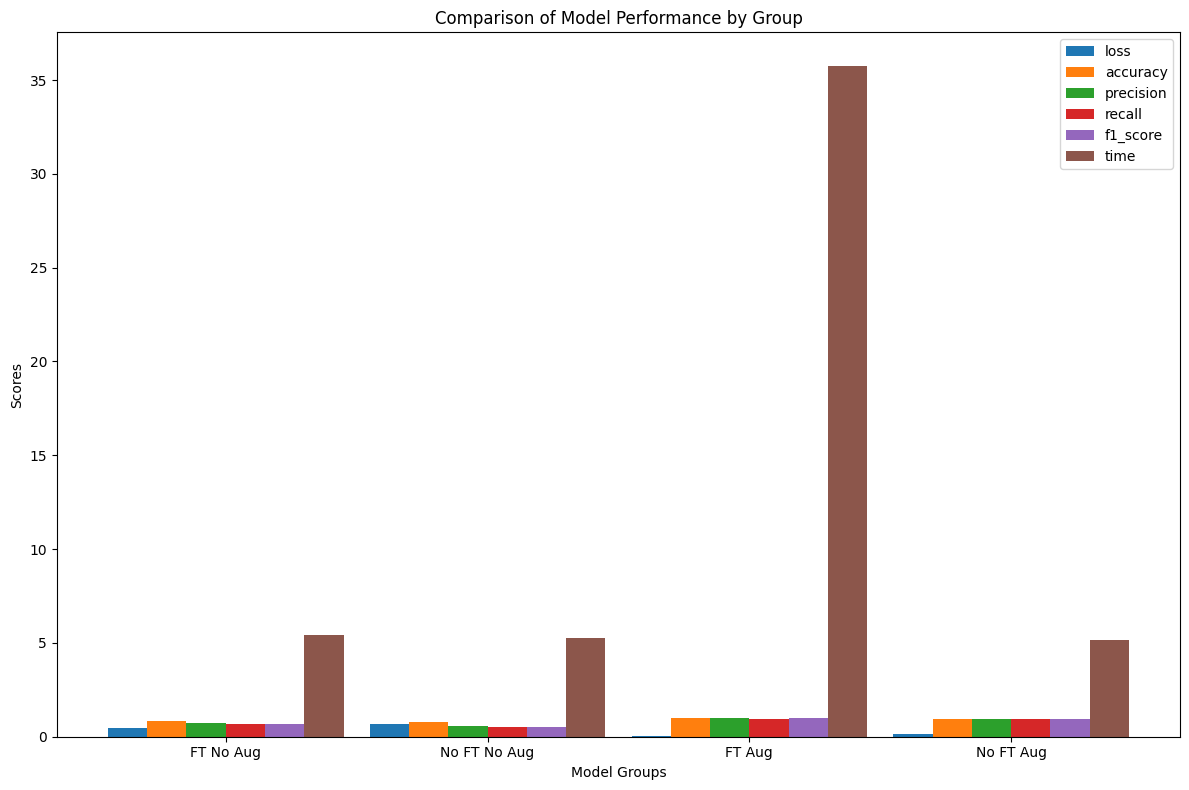

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Đường dẫn checkpoint theo nhóm
checkpoints_ft_no_aug = [
    'Checkpoint_FT/mobileNet_V1_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V2_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Small_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Large_finetuned_final.keras',
    'Checkpoint_FT/EfficientNet_B0_finetuned_final.keras'
]

checkpoints_no_ft_no_aug = [
    'Checkpoint_FE/mobileNet_V1_FE.keras',
    'Checkpoint_FE/mobileNet_V2_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Small_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Large_FE.keras',
    'Checkpoint_FE/EfficientNet_B0_FE.keras'
]

checkpoints_ft_aug = [
    'Checkpoint_FT_Aug/mobileNet_V1_finetuned_aug.keras',
    'Checkpoint_FT_Aug/MobileNet_V2_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Small_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Large_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/EfficientNet_B0_finetuned_final_Aug.keras'
]

checkpoints_no_ft_aug = [
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V1_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V2_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Large_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Small_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/efficientNet_B0_Aug.keras'
]

# Đường dẫn dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Chia dataset cho test
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(max(1, val_batches // 5))
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))


# Hàm đánh giá mô hình
def evaluate_model(checkpoint_files, test_dataset):
    results = []
    for checkpoint_file in checkpoint_files:
        start_time = time.time()

        # Load mô hình
        model = load_model(checkpoint_file)

        # Đánh giá trên tập test
        loss, accuracy = model.evaluate(test_dataset, verbose=0)

        # Lấy batch ảnh và nhãn
        image_batch, label_batch = next(iter(test_dataset))
        predictions_probs = model.predict_on_batch(image_batch)
        predictions = np.argmax(predictions_probs, axis=1)
        labels = np.argmax(label_batch, axis=1)

        # Tính toán các chỉ số
        precision = precision_score(labels, predictions, average='macro')
        recall = recall_score(labels, predictions, average='macro')
        f1 = f1_score(labels, predictions, average='macro')

        # Thời gian chạy
        elapsed_time = time.time() - start_time

        # Lưu kết quả
        results.append({
            'loss': loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'time': elapsed_time
        })
    return results


# Tính trung bình kết quả
def calculate_mean(results):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'time']
    mean_results = {metric: np.mean([r[metric] for r in results]) for metric in metrics}
    return mean_results


# Đánh giá từng nhóm
results_ft_no_aug = evaluate_model(checkpoints_ft_no_aug, test_dataset)
results_no_ft_no_aug = evaluate_model(checkpoints_no_ft_no_aug, test_dataset)
results_ft_aug = evaluate_model(checkpoints_ft_aug, test_dataset)
results_no_ft_aug = evaluate_model(checkpoints_no_ft_aug, test_dataset)

# Tính trung bình cho từng nhóm
mean_ft_no_aug = calculate_mean(results_ft_no_aug)
mean_no_ft_no_aug = calculate_mean(results_no_ft_no_aug)
mean_ft_aug = calculate_mean(results_ft_aug)
mean_no_ft_aug = calculate_mean(results_no_ft_aug)

# Chuẩn bị dữ liệu vẽ biểu đồ
group_names = ['FT No Aug', 'No FT No Aug', 'FT Aug', 'No FT Aug']
mean_values = [
    mean_ft_no_aug,
    mean_no_ft_no_aug,
    mean_ft_aug,
    mean_no_ft_aug
]

metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'time']
data = {metric: [group[metric] for group in mean_values] for metric in metrics}

# Vẽ biểu đồ
x = np.arange(len(group_names))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 8))

# Vẽ cột cho từng chỉ số
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, data[metric], width, label=metric)

# Gắn tên nhóm vào trục x
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(group_names)

# Thêm tiêu đề, nhãn và chú thích
ax.set_title('Comparison of Model Performance by Group')
ax.set_xlabel('Model Groups')
ax.set_ylabel('Scores')
ax.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.


D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWar

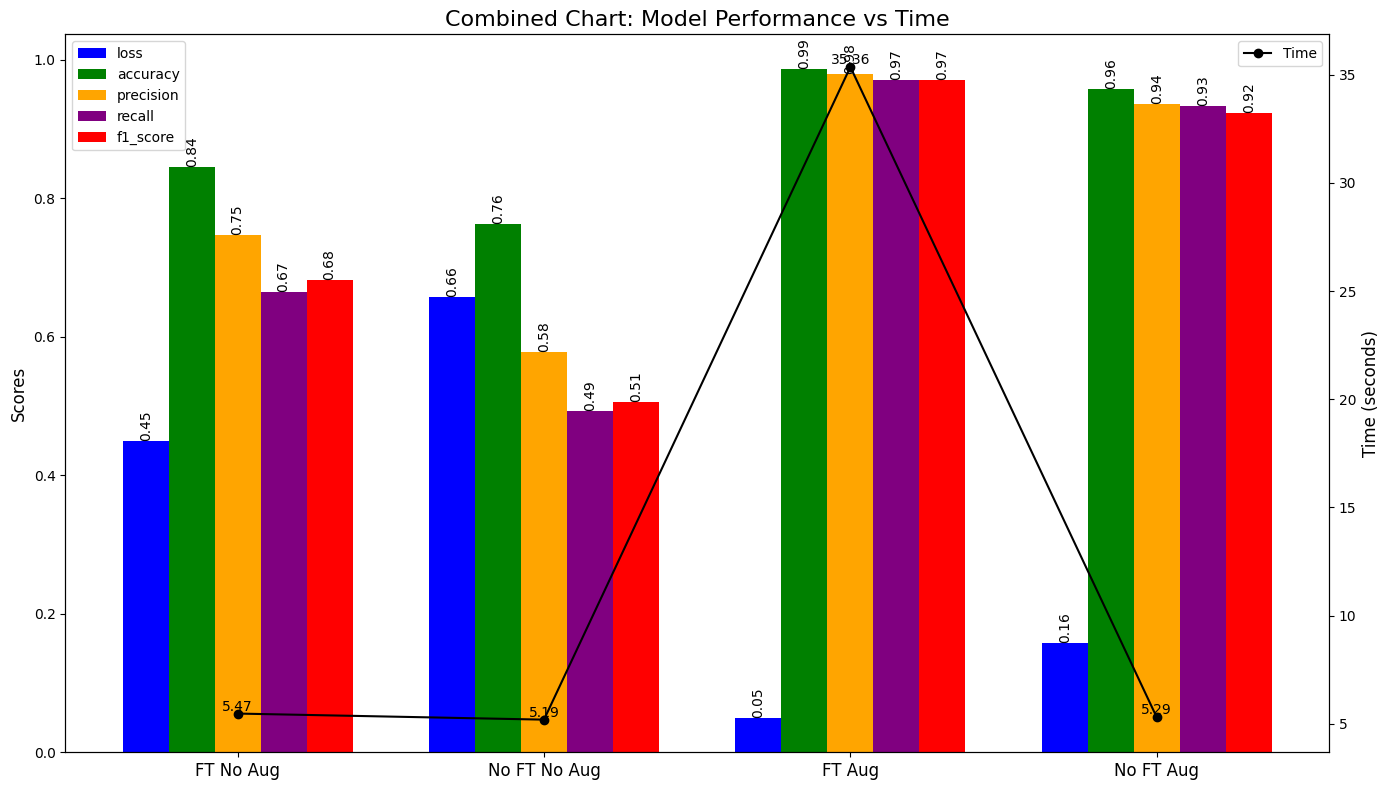

In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Đường dẫn checkpoint theo nhóm
checkpoints_ft_no_aug = [
    'Checkpoint_FT/mobileNet_V1_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V2_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Small_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Large_finetuned_final.keras',
    'Checkpoint_FT/EfficientNet_B0_finetuned_final.keras'
]

checkpoints_no_ft_no_aug = [
    'Checkpoint_FE/mobileNet_V1_FE.keras',
    'Checkpoint_FE/mobileNet_V2_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Small_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Large_FE.keras',
    'Checkpoint_FE/EfficientNet_B0_FE.keras'
]

checkpoints_ft_aug = [
    'Checkpoint_FT_Aug/mobileNet_V1_finetuned_aug.keras',
    'Checkpoint_FT_Aug/MobileNet_V2_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Small_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Large_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/EfficientNet_B0_finetuned_final_Aug.keras'
]

checkpoints_no_ft_aug = [
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V1_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V2_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Large_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Small_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/efficientNet_B0_Aug.keras'
]

# Đường dẫn dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Chia dataset cho test
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(max(1, val_batches // 5))
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Hàm đánh giá mô hình
def evaluate_model(checkpoint_files, test_dataset):
    results = []
    for checkpoint_file in checkpoint_files:
        start_time = time.time()

        # Load mô hình
        model = load_model(checkpoint_file)

        # Đánh giá trên tập test
        loss, accuracy = model.evaluate(test_dataset, verbose=0)

        # Lấy batch ảnh và nhãn
        image_batch, label_batch = next(iter(test_dataset))
        predictions_probs = model.predict_on_batch(image_batch)
        predictions = np.argmax(predictions_probs, axis=1)
        labels = np.argmax(label_batch, axis=1)

        # Tính toán các chỉ số
        precision = precision_score(labels, predictions, average='macro')
        recall = recall_score(labels, predictions, average='macro')
        f1 = f1_score(labels, predictions, average='macro')

        # Thời gian chạy
        elapsed_time = time.time() - start_time

        # Lưu kết quả
        results.append({
            'loss': loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'time': elapsed_time
        })
    return results

# Tính trung bình kết quả
def calculate_mean(results):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'time']
    mean_results = {metric: np.mean([r[metric] for r in results]) for metric in metrics}
    return mean_results

# Đánh giá từng nhóm
results_ft_no_aug = evaluate_model(checkpoints_ft_no_aug, test_dataset)
results_no_ft_no_aug = evaluate_model(checkpoints_no_ft_no_aug, test_dataset)
results_ft_aug = evaluate_model(checkpoints_ft_aug, test_dataset)
results_no_ft_aug = evaluate_model(checkpoints_no_ft_aug, test_dataset)

# Tính trung bình cho từng nhóm
mean_ft_no_aug = calculate_mean(results_ft_no_aug)
mean_no_ft_no_aug = calculate_mean(results_no_ft_no_aug)
mean_ft_aug = calculate_mean(results_ft_aug)
mean_no_ft_aug = calculate_mean(results_no_ft_aug)

# Chuẩn bị dữ liệu vẽ biểu đồ
group_names = ['FT No Aug', 'No FT No Aug', 'FT Aug', 'No FT Aug']
mean_values = [
    mean_ft_no_aug,
    mean_no_ft_no_aug,
    mean_ft_aug,
    mean_no_ft_aug
]

metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'time']
data = {metric: [group[metric] for group in mean_values] for metric in metrics}

# Vẽ biểu đồ kết hợp cột và đường
fig, ax1 = plt.subplots(figsize=(14, 8))

x = np.arange(len(group_names))  # Tạo vị trí cho các nhóm
width = 0.15  # Độ rộng cột

# Vẽ cột cho các chỉ số (loss, accuracy, precision, recall, f1_score)
colors = ['blue', 'green', 'orange', 'purple', 'red']
for i, metric in enumerate(metrics[:-1]):  # Loại bỏ metric "time" vì nó dùng đường
    bars = ax1.bar(x + i * width, data[metric], width, label=metric, color=colors[i])
    # Hiển thị giá trị trên đầu cột
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
                 ha='center', va='bottom', fontsize=10, rotation=90)

# Cài đặt trục chính (trục y cho các chỉ số cột)
ax1.set_ylabel('Scores', fontsize=12)
ax1.set_title('Combined Chart: Model Performance vs Time', fontsize=16)
ax1.set_xticks(x + width * (len(metrics[:-1]) - 1) / 2)
ax1.set_xticklabels(group_names, fontsize=12)
ax1.legend(loc='upper left', fontsize=10)

# Vẽ đường cho "time" trên trục y thứ hai
ax2 = ax1.twinx()
ax2.plot(x + width * 2, data['time'], color='black', marker='o', linestyle='-', label='Time')
# Hiển thị giá trị trên đường
for i, t in enumerate(data['time']):
    ax2.text(x[i] + width * 2, t, f'{t:.2f}', ha='center', va='bottom', fontsize=10)

# Cài đặt trục phụ (trục y cho thời gian)
ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)

# Điều chỉnh bố cục
fig.tight_layout()
plt.show()


Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Checkpoint: Checkpoint_FT_Aug\mobileNet_V1_finetuned_aug.keras
Loss: 0.0909
Accuracy: 0.9665
Precision: 0.8758
Recall: 0.8782
F1 Score: 0.8741
Time: 6.3834 seconds
----------------------------------------
Checkpoint: Checkpoint_FT_Aug\MobileNet_V2_finetuned_final_Aug.keras
Loss: 0.0433
Accuracy: 0.9955
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Time: 79.8009 seconds
----------------------------------------
Checkpoint: Checkpoint_FT_Aug\mobileNet_V3_Small_finetuned_final_Aug.keras
Loss: 0.1263
Accuracy: 0.9665
Precision: 0.9487
Recall: 0.8750
F1 Score: 0.8988
Time: 3.0680 seconds
----------------------------------------
Checkpoint: Checkpoint_FT_Aug\mobileNet_V3_Large_finetuned_final_Aug.keras
Loss: 0.0046
Accuracy: 0.9978
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Time: 5.4300 seconds
----------------------------------------
C

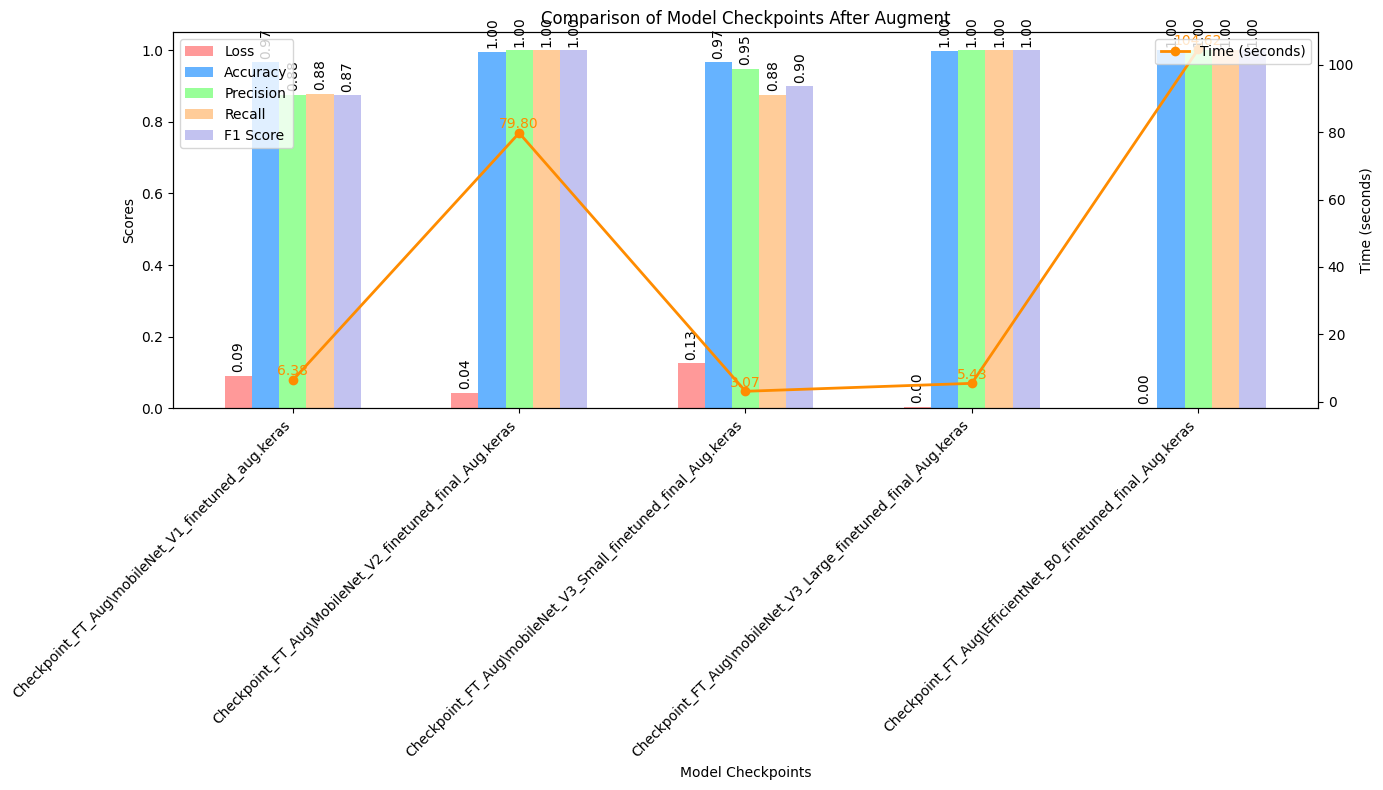

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Đường dẫn tới các checkpoint mô hình
checkpoint_files = [
    'Checkpoint_FT_Aug\mobileNet_V1_finetuned_aug.keras',
    'Checkpoint_FT_Aug\MobileNet_V2_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug\mobileNet_V3_Small_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug\mobileNet_V3_Large_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug\EfficientNet_B0_finetuned_final_Aug.keras'
]

# Đường dẫn tới dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tính số batch trong validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Tạo test dataset từ validation dataset (lấy 20% dữ liệu)
test_dataset = validation_dataset.take(max(1, val_batches // 5))

# Cập nhật lại validation_dataset bằng cách bỏ qua phần đã lấy cho test
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Danh sách lưu kết quả
results = []

# Đánh giá mô hình trên tập test
for checkpoint_file in checkpoint_files:
    start_time = time.time()  # Đo thời gian bắt đầu
    
    # Load mô hình
    model = load_model(checkpoint_file)

    # Đánh giá mô hình trên test dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Lấy batch ảnh và nhãn để dự đoán
    image_batch, label_batch = next(iter(test_dataset))
    predictions_probs = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions_probs, axis=1)
    labels = np.argmax(label_batch, axis=1)

    # Tính toán các chỉ số
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # Đo thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time  # Tính thời gian

    # Lưu kết quả
    results.append({
        'checkpoint': checkpoint_file,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'time': elapsed_time  # Lưu thời gian
    })

    # In kết quả đánh giá cho từng checkpoint
    print(f"Checkpoint: {checkpoint_file}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Time: {elapsed_time:.4f} seconds")
    print("-" * 40)

# Vẽ biểu đồ so sánh
model_names = [result['checkpoint'] for result in results]
losses = [result['loss'] for result in results]
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
f1_scores = [result['f1_score'] for result in results]
times = [result['time'] for result in results]  # Thời gian

x = np.arange(len(model_names))  # Vị trí của các cột
width = 0.12  # Độ rộng của mỗi cột

# Tạo figure và axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Vẽ các cột cho các chỉ số đánh giá
bar1 = ax1.bar(x - 2 * width, losses, width, label='Loss', color='#ff9999')
bar2 = ax1.bar(x - width, accuracies, width, label='Accuracy', color='#66b3ff')
bar3 = ax1.bar(x, precisions, width, label='Precision', color='#99ff99')
bar4 = ax1.bar(x + width, recalls, width, label='Recall', color='#ffcc99')
bar5 = ax1.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='#c2c2f0')

# Tạo trục y thứ hai cho thời gian
ax2 = ax1.twinx()
line = ax2.plot(x, times, label='Time (seconds)', color='darkorange', marker='o', linewidth=2)

# Gắn tên các mô hình vào trục x
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha="right")

# Thêm tiêu đề và nhãn
ax1.set_xlabel("Model Checkpoints")
ax1.set_ylabel("Scores")
ax2.set_ylabel("Time (seconds)")
ax1.set_title("Comparison of Model Checkpoints After Augment")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Hiển thị giá trị trên mỗi cột
def add_labels(bars, vertical=False):
    for bar in bars:
        yval = bar.get_height()
        if vertical:
            ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', rotation=90)
        else:
            ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

add_labels(bar1, vertical=True)
add_labels(bar2, vertical=True)
add_labels(bar3, vertical=True)
add_labels(bar4, vertical=True)
add_labels(bar5, vertical=True)

# Hiển thị giá trị trên đường thời gian
for i, yval in enumerate(times):
    ax2.text(x[i], yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', color='darkorange')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Checkpoint: Checkpoit_FE_Aug\mobileNet_V1_FE_Aug.keras
Loss: 0.1993
Accuracy: 0.9308
Precision: 0.8607
Recall: 0.8718
F1 Score: 0.8630
Time: 4.4922 seconds
----------------------------------------
Checkpoint: Checkpoit_FE_Aug\mobileNet_V2_FE_Aug.keras
Loss: 0.1523
Accuracy: 0.9576
Precision: 0.9615
Recall: 0.9286
F1 Score: 0.9375
Time: 5.7087 seconds
----------------------------------------
Checkpoint: Checkpoit_FE_Aug\mobileNet_V3_Small_FE_Aug.keras
Loss: 0.1989
Accuracy: 0.9464
Precision: 0.9487
Recall: 0.8750
F1 Score: 0.8988
Time: 3.6352 seconds
----------------------------------------
Checkpoint: Checkpoit_FE_Aug\mobileNet_V3_Large_FE_Aug.keras
Loss: 0.1411
Accuracy: 0.9554
Precision: 0.9545
Recall: 0.9116
F1 Score: 0.9224
Time: 5.8152 seconds
----------------------------------------
Checkpoint: Checkpoit_FE_Aug\efficientNet_B0_Aug.ker

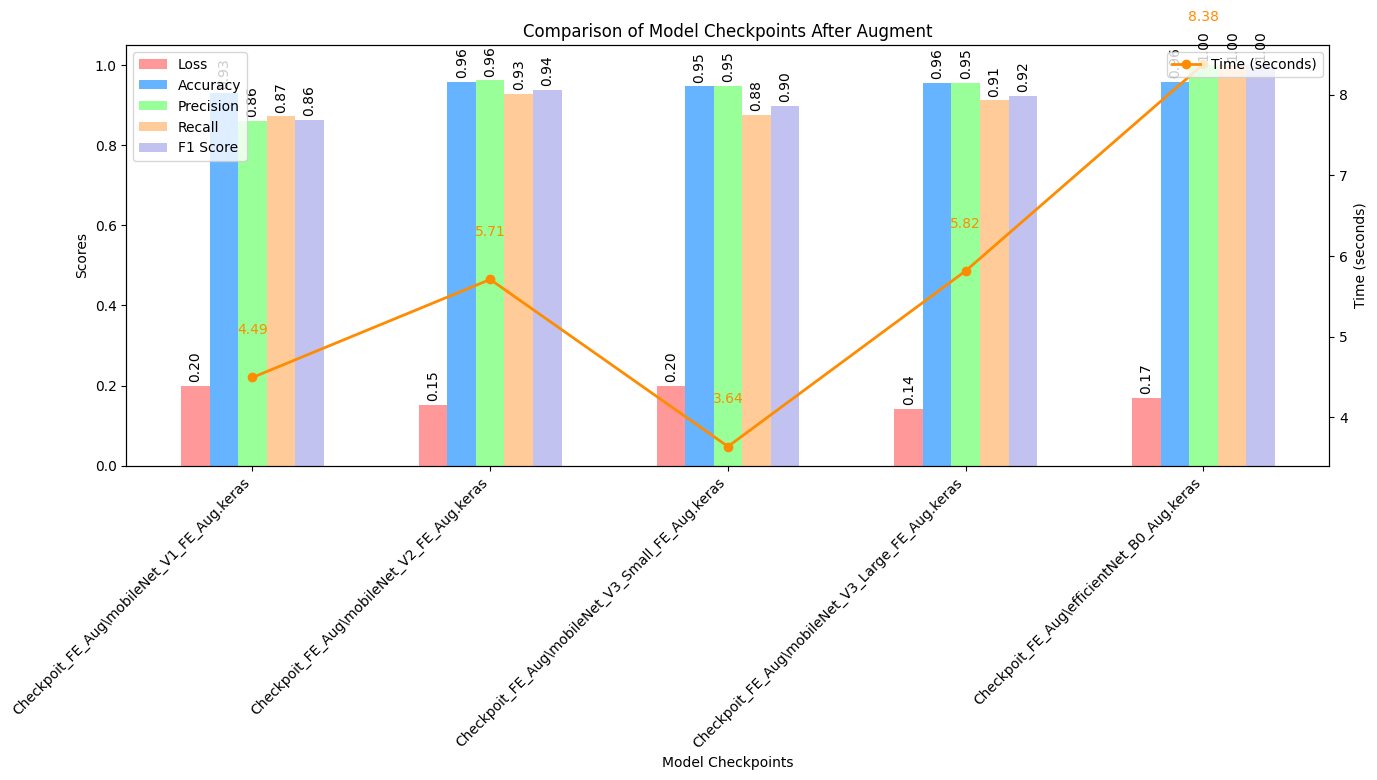

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Đường dẫn tới các checkpoint mô hình
checkpoint_files = [
    'Checkpoit_FE_Aug\mobileNet_V1_FE_Aug.keras',
    'Checkpoit_FE_Aug\mobileNet_V2_FE_Aug.keras',
    'Checkpoit_FE_Aug\mobileNet_V3_Small_FE_Aug.keras',
    'Checkpoit_FE_Aug\mobileNet_V3_Large_FE_Aug.keras',
    'Checkpoit_FE_Aug\efficientNet_B0_Aug.keras'
]

# Đường dẫn tới dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tính số batch trong validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Tạo test dataset từ validation dataset (lấy 20% dữ liệu)
test_dataset = validation_dataset.take(max(1, val_batches // 5))

# Cập nhật lại validation_dataset bằng cách bỏ qua phần đã lấy cho test
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Danh sách lưu kết quả
results = []

# Đánh giá mô hình trên tập test
for checkpoint_file in checkpoint_files:
    start_time = time.time()  # Đo thời gian bắt đầu
    
    # Load mô hình
    model = load_model(checkpoint_file)

    # Đánh giá mô hình trên test dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Lấy batch ảnh và nhãn để dự đoán
    image_batch, label_batch = next(iter(test_dataset))
    predictions_probs = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions_probs, axis=1)
    labels = np.argmax(label_batch, axis=1)

    # Tính toán các chỉ số
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # Đo thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time  # Tính thời gian

    # Lưu kết quả
    results.append({
        'checkpoint': checkpoint_file,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'time': elapsed_time  # Lưu thời gian
    })

    # In kết quả đánh giá cho từng checkpoint
    print(f"Checkpoint: {checkpoint_file}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Time: {elapsed_time:.4f} seconds")
    print("-" * 40)

# Vẽ biểu đồ so sánh
model_names = [result['checkpoint'] for result in results]
losses = [result['loss'] for result in results]
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
f1_scores = [result['f1_score'] for result in results]
times = [result['time'] for result in results]  # Thời gian

x = np.arange(len(model_names))  # Vị trí của các cột
width = 0.12  # Độ rộng của mỗi cột

# Tạo figure và axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Vẽ các cột cho các chỉ số đánh giá
bar1 = ax1.bar(x - 2 * width, losses, width, label='Loss', color='#ff9999')
bar2 = ax1.bar(x - width, accuracies, width, label='Accuracy', color='#66b3ff')
bar3 = ax1.bar(x, precisions, width, label='Precision', color='#99ff99')
bar4 = ax1.bar(x + width, recalls, width, label='Recall', color='#ffcc99')
bar5 = ax1.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='#c2c2f0')

# Tạo trục y thứ hai cho thời gian
ax2 = ax1.twinx()
line = ax2.plot(x, times, label='Time (seconds)', color='darkorange', marker='o', linewidth=2)

# Gắn tên các mô hình vào trục x
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha="right")

# Thêm tiêu đề và nhãn
ax1.set_xlabel("Model Checkpoints")
ax1.set_ylabel("Scores")
ax2.set_ylabel("Time (seconds)")
ax1.set_title("Comparison of Model Checkpoints After Augment")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Hiển thị giá trị trên mỗi cột
def add_labels(bars, vertical=False):
    for bar in bars:
        yval = bar.get_height()
        if vertical:
            ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', rotation=90)
        else:
            ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

add_labels(bar1, vertical=True)
add_labels(bar2, vertical=True)
add_labels(bar3, vertical=True)
add_labels(bar4, vertical=True)
add_labels(bar5, vertical=True)

# Hiển thị giá trị trên đường thời gian
for i, yval in enumerate(times):
    ax2.text(x[i], yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', color='darkorange')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Checkpoint: checkpoint_FT\mobileNet_V1_finetuned_final.keras
Loss: 0.3911
Accuracy: 0.8638
Precision: 0.8938
Recall: 0.6474
F1 Score: 0.6787
Time: 4.6673 seconds
----------------------------------------
Checkpoint: checkpoint_FT\mobileNet_V2_finetuned_final.keras
Loss: 0.4091
Accuracy: 0.8571
Precision: 0.7413
Recall: 0.7316
F1 Score: 0.7265
Time: 5.6267 seconds
----------------------------------------


D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Checkpoint: checkpoint_FT\mobileNet_V3_Small_finetuned_final.keras
Loss: 0.5361
Accuracy: 0.7991
Precision: 0.4932
Recall: 0.5190
F1 Score: 0.5027
Time: 3.2501 seconds
----------------------------------------
Checkpoint: checkpoint_FT\mobileNet_V3_Large_finetuned_final.keras
Loss: 0.4155
Accuracy: 0.8482
Precision: 0.9020
Recall: 0.7449
F1 Score: 0.8067
Time: 5.6370 seconds
----------------------------------------


D:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Checkpoint: checkpoint_FT\EfficientNet_B0_finetuned_final.keras
Loss: 0.4941
Accuracy: 0.8527
Precision: 0.7031
Recall: 0.6821
F1 Score: 0.6923
Time: 8.8372 seconds
----------------------------------------


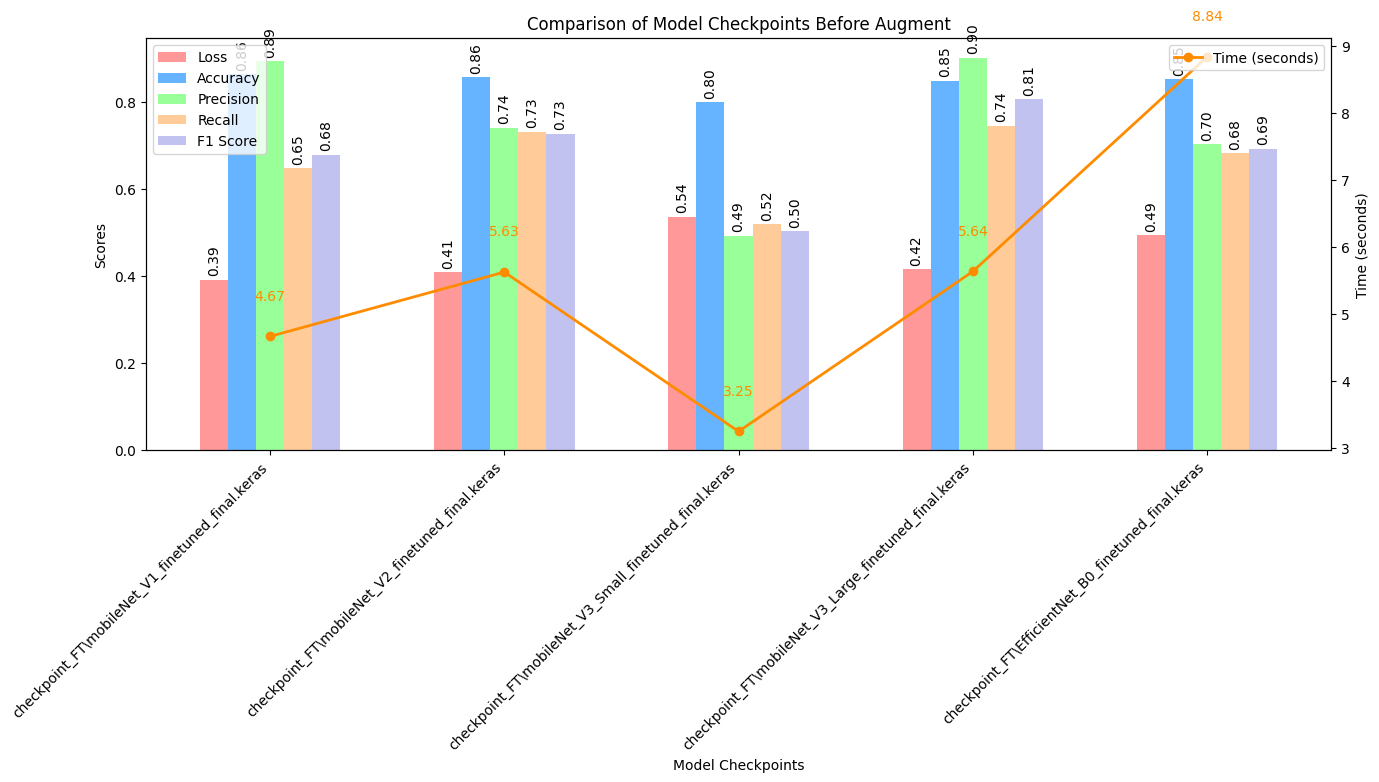

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Đường dẫn tới các checkpoint mô hình
checkpoint_files = [
    'checkpoint_FT\mobileNet_V1_finetuned_final.keras',
    'checkpoint_FT\mobileNet_V2_finetuned_final.keras',
    'checkpoint_FT\mobileNet_V3_Small_finetuned_final.keras',
    'checkpoint_FT\mobileNet_V3_Large_finetuned_final.keras',
    'checkpoint_FT\EfficientNet_B0_finetuned_final.keras'
]

# Đường dẫn tới dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tính số batch trong validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Tạo test dataset từ validation dataset (lấy 20% dữ liệu)
test_dataset = validation_dataset.take(max(1, val_batches // 5))

# Cập nhật lại validation_dataset bằng cách bỏ qua phần đã lấy cho test
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Danh sách lưu kết quả
results = []

# Đánh giá mô hình trên tập test
for checkpoint_file in checkpoint_files:
    start_time = time.time()  # Đo thời gian bắt đầu
    
    # Load mô hình
    model = load_model(checkpoint_file)

    # Đánh giá mô hình trên test dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Lấy batch ảnh và nhãn để dự đoán
    image_batch, label_batch = next(iter(test_dataset))
    predictions_probs = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions_probs, axis=1)
    labels = np.argmax(label_batch, axis=1)

    # Tính toán các chỉ số
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # Đo thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time  # Tính thời gian

    # Lưu kết quả
    results.append({
        'checkpoint': checkpoint_file,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'time': elapsed_time  # Lưu thời gian
    })

    # In kết quả đánh giá cho từng checkpoint
    print(f"Checkpoint: {checkpoint_file}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Time: {elapsed_time:.4f} seconds")
    print("-" * 40)

# Vẽ biểu đồ so sánh
model_names = [result['checkpoint'] for result in results]
losses = [result['loss'] for result in results]
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
f1_scores = [result['f1_score'] for result in results]
times = [result['time'] for result in results]  # Thời gian

x = np.arange(len(model_names))  # Vị trí của các cột
width = 0.12  # Độ rộng của mỗi cột

# Tạo figure và axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Vẽ các cột cho các chỉ số đánh giá
bar1 = ax1.bar(x - 2 * width, losses, width, label='Loss', color='#ff9999')
bar2 = ax1.bar(x - width, accuracies, width, label='Accuracy', color='#66b3ff')
bar3 = ax1.bar(x, precisions, width, label='Precision', color='#99ff99')
bar4 = ax1.bar(x + width, recalls, width, label='Recall', color='#ffcc99')
bar5 = ax1.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='#c2c2f0')

# Tạo trục y thứ hai cho thời gian
ax2 = ax1.twinx()
line = ax2.plot(x, times, label='Time (seconds)', color='darkorange', marker='o', linewidth=2)

# Gắn tên các mô hình vào trục x
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha="right")

# Thêm tiêu đề và nhãn
ax1.set_xlabel("Model Checkpoints")
ax1.set_ylabel("Scores")
ax2.set_ylabel("Time (seconds)")
ax1.set_title("Comparison of Model Checkpoints Before Augment")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Hiển thị giá trị trên mỗi cột
def add_labels(bars, vertical=False):
    for bar in bars:
        yval = bar.get_height()
        if vertical:
            ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', rotation=90)
        else:
            ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

add_labels(bar1, vertical=True)
add_labels(bar2, vertical=True)
add_labels(bar3, vertical=True)
add_labels(bar4, vertical=True)
add_labels(bar5, vertical=True)

# Hiển thị giá trị trên đường thời gian
for i, yval in enumerate(times):
    ax2.text(x[i], yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', color='darkorange')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Đường dẫn tới các checkpoint mô hình
checkpoint_files = [
    'checkpoint_FT\mobileNet_V1_finetuned_final.keras',
    'checkpoint_FT\mobileNet_V2_finetuned_final.keras',
    'checkpoint_FT\mobileNet_V3_Small_finetuned_final.keras',
    'checkpoint_FT\mobileNet_V3_Large_finetuned_final.keras',
    'checkpoint_FT\EfficientNet_B0_finetuned_final.keras'
]

# Đường dẫn tới dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tính số batch trong validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Tạo test dataset từ validation dataset (lấy 20% dữ liệu)
test_dataset = validation_dataset.take(max(1, val_batches // 5))

# Cập nhật lại validation_dataset bằng cách bỏ qua phần đã lấy cho test
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Danh sách lưu kết quả
results = []

# Đánh giá mô hình trên tập test
for checkpoint_file in checkpoint_files:
    start_time = time.time()  # Đo thời gian bắt đầu
    
    # Load mô hình
    model = load_model(checkpoint_file)

    # Đánh giá mô hình trên test dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Lấy batch ảnh và nhãn để dự đoán
    image_batch, label_batch = next(iter(test_dataset))
    predictions_probs = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions_probs, axis=1)
    labels = np.argmax(label_batch, axis=1)

    # Tính toán các chỉ số
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # Đo thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time  # Tính thời gian

    # Lưu kết quả
    results.append({
        'checkpoint': checkpoint_file,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'time': elapsed_time  # Lưu thời gian
    })

    # In kết quả đánh giá cho từng checkpoint
    print(f"Checkpoint: {checkpoint_file}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Time: {elapsed_time:.4f} seconds")
    print("-" * 40)

# Vẽ biểu đồ so sánh
model_names = [result['checkpoint'] for result in results]
losses = [result['loss'] for result in results]
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
f1_scores = [result['f1_score'] for result in results]
times = [result['time'] for result in results]  # Thời gian

x = np.arange(len(model_names))  # Vị trí của các cột
width = 0.12  # Độ rộng của mỗi cột

# Tạo figure và axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Vẽ các cột cho các chỉ số đánh giá
bar1 = ax1.bar(x - 2 * width, losses, width, label='Loss', color='#ff9999')
bar2 = ax1.bar(x - width, accuracies, width, label='Accuracy', color='#66b3ff')
bar3 = ax1.bar(x, precisions, width, label='Precision', color='#99ff99')
bar4 = ax1.bar(x + width, recalls, width, label='Recall', color='#ffcc99')
bar5 = ax1.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='#c2c2f0')

# Tạo trục y thứ hai cho thời gian
ax2 = ax1.twinx()
line = ax2.plot(x, times, label='Time (seconds)', color='darkorange', marker='o', linewidth=2)

# Gắn tên các mô hình vào trục x
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha="right")

# Thêm tiêu đề và nhãn
ax1.set_xlabel("Model Checkpoints")
ax1.set_ylabel("Scores")
ax2.set_ylabel("Time (seconds)")
ax1.set_title("Comparison of Model Checkpoints Before Augment")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Hiển thị giá trị trên mỗi cột
def add_labels(bars, vertical=False):
    for bar in bars:
        yval = bar.get_height()
        if vertical:
            ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', rotation=90)
        else:
            ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

add_labels(bar1, vertical=True)
add_labels(bar2, vertical=True)
add_labels(bar3, vertical=True)
add_labels(bar4, vertical=True)
add_labels(bar5, vertical=True)

# Hiển thị giá trị trên đường thời gian
for i, yval in enumerate(times):
    ax2.text(x[i], yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', color='darkorange')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [1]:
import os

checkpoint_path = "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V1_FE.keras"
file_size = os.path.getsize(checkpoint_path)  # Kích thước file tính bằng bytes
print(f"Checkpoint size: {file_size / (1024 ** 2):.2f} MB")


Checkpoint size: 12.66 MB


In [2]:
import tensorflow as tf
import tracemalloc

# Bắt đầu theo dõi bộ nhớ
tracemalloc.start()

# Load mô hình từ checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V1_FE.keras")

# Lấy bộ nhớ sử dụng
current, peak = tracemalloc.get_traced_memory()
print(f"Memory usage when loading model: {current / (1024 ** 2):.2f} MB")
print(f"Peak memory usage: {peak / (1024 ** 2):.2f} MB")

# Dừng theo dõi
tracemalloc.stop()


Memory usage when loading model: 13.81 MB
Peak memory usage: 39.17 MB


In [4]:
import tensorflow as tf
import psutil
import os

# Lấy thông tin bộ nhớ trước khi load checkpoint
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 ** 2)  # RAM in MB

# Load checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V1_FE.keras")

# Lấy thông tin bộ nhớ sau khi load checkpoint
mem_after = process.memory_info().rss / (1024 ** 2)  # RAM in MB

print(f"Memory used to load the checkpoint: {mem_after - mem_before:.2f} MB")


Memory used to load the checkpoint: 16.58 MB


In [5]:
import numpy as np

# Dự đoán một batch dữ liệu
input_data = np.random.random((1, 224, 224, 3))  # Thay đổi tùy theo input shape của mô hình

mem_before = process.memory_info().rss / (1024 ** 2)
predictions = model.predict(input_data)
mem_after = process.memory_info().rss / (1024 ** 2)

print(f"Memory used during prediction: {mem_after - mem_before:.2f} MB")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
Memory used during prediction: 30.22 MB


In [6]:
import os

checkpoint_path = "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V2_FE.keras"
file_size = os.path.getsize(checkpoint_path)  # Kích thước file tính bằng bytes
print(f"Checkpoint size: {file_size / (1024 ** 2):.2f} MB")
import tensorflow as tf
import tracemalloc

# Bắt đầu theo dõi bộ nhớ
tracemalloc.start()

# Load mô hình từ checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V2_FE.keras")

# Lấy bộ nhớ sử dụng
current, peak = tracemalloc.get_traced_memory()
print(f"Memory usage when loading model: {current / (1024 ** 2):.2f} MB")
print(f"Peak memory usage: {peak / (1024 ** 2):.2f} MB")

# Dừng theo dõi
tracemalloc.stop()
import tensorflow as tf
import psutil
import os

# Lấy thông tin bộ nhớ trước khi load checkpoint
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 ** 2)  # RAM in MB

# Load checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V2_FE.keras")

# Lấy thông tin bộ nhớ sau khi load checkpoint
mem_after = process.memory_info().rss / (1024 ** 2)  # RAM in MB

print(f"Memory used to load the checkpoint: {mem_after - mem_before:.2f} MB")
import numpy as np

# Dự đoán một batch dữ liệu
input_data = np.random.random((1, 224, 224, 3))  # Thay đổi tùy theo input shape của mô hình

mem_before = process.memory_info().rss / (1024 ** 2)
predictions = model.predict(input_data)
mem_after = process.memory_info().rss / (1024 ** 2)

print(f"Memory used during prediction: {mem_after - mem_before:.2f} MB")


Checkpoint size: 9.19 MB
Memory usage when loading model: 6.57 MB
Peak memory usage: 25.08 MB
Memory used to load the checkpoint: 11.15 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
Memory used during prediction: 26.79 MB


In [7]:
import os

checkpoint_path = "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V3_Large_FE.keras"
file_size = os.path.getsize(checkpoint_path)  # Kích thước file tính bằng bytes
print(f"Checkpoint size: {file_size / (1024 ** 2):.2f} MB")
import tensorflow as tf
import tracemalloc

# Bắt đầu theo dõi bộ nhớ
tracemalloc.start()

# Load mô hình từ checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V3_Large_FE.keras")

# Lấy bộ nhớ sử dụng
current, peak = tracemalloc.get_traced_memory()
print(f"Memory usage when loading model: {current / (1024 ** 2):.2f} MB")
print(f"Peak memory usage: {peak / (1024 ** 2):.2f} MB")

# Dừng theo dõi
tracemalloc.stop()
import tensorflow as tf
import psutil
import os

# Lấy thông tin bộ nhớ trước khi load checkpoint
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 ** 2)  # RAM in MB

# Load checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V3_Large_FE.keras")

# Lấy thông tin bộ nhớ sau khi load checkpoint
mem_after = process.memory_info().rss / (1024 ** 2)  # RAM in MB

print(f"Memory used to load the checkpoint: {mem_after - mem_before:.2f} MB")
import numpy as np

# Dự đoán một batch dữ liệu
input_data = np.random.random((1, 224, 224, 3))  # Thay đổi tùy theo input shape của mô hình

mem_before = process.memory_info().rss / (1024 ** 2)
predictions = model.predict(input_data)
mem_after = process.memory_info().rss / (1024 ** 2)

print(f"Memory used during prediction: {mem_after - mem_before:.2f} MB")


Checkpoint size: 12.08 MB
Memory usage when loading model: 4.06 MB
Peak memory usage: 28.45 MB
Memory used to load the checkpoint: 16.79 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Memory used during prediction: 29.72 MB


In [8]:
import os

checkpoint_path = "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V3_Small_FE.keras"
file_size = os.path.getsize(checkpoint_path)  # Kích thước file tính bằng bytes
print(f"Checkpoint size: {file_size / (1024 ** 2):.2f} MB")
import tensorflow as tf
import tracemalloc

# Bắt đầu theo dõi bộ nhớ
tracemalloc.start()

# Load mô hình từ checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V3_Small_FE.keras")

# Lấy bộ nhớ sử dụng
current, peak = tracemalloc.get_traced_memory()
print(f"Memory usage when loading model: {current / (1024 ** 2):.2f} MB")
print(f"Peak memory usage: {peak / (1024 ** 2):.2f} MB")

# Dừng theo dõi
tracemalloc.stop()
import tensorflow as tf
import psutil
import os

# Lấy thông tin bộ nhớ trước khi load checkpoint
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 ** 2)  # RAM in MB

# Load checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/mobileNet_V3_Small_FE.keras")

# Lấy thông tin bộ nhớ sau khi load checkpoint
mem_after = process.memory_info().rss / (1024 ** 2)  # RAM in MB

print(f"Memory used to load the checkpoint: {mem_after - mem_before:.2f} MB")
import numpy as np

# Dự đoán một batch dữ liệu
input_data = np.random.random((1, 224, 224, 3))  # Thay đổi tùy theo input shape của mô hình

mem_before = process.memory_info().rss / (1024 ** 2)
predictions = model.predict(input_data)
mem_after = process.memory_info().rss / (1024 ** 2)

print(f"Memory used during prediction: {mem_after - mem_before:.2f} MB")


Checkpoint size: 4.11 MB
Memory usage when loading model: 3.51 MB
Peak memory usage: 11.95 MB
Memory used to load the checkpoint: 1.05 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
Memory used during prediction: 7.41 MB


In [9]:
import os

checkpoint_path = "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/EfficientNet_B0_FE.keras"
file_size = os.path.getsize(checkpoint_path)  # Kích thước file tính bằng bytes
print(f"Checkpoint size: {file_size / (1024 ** 2):.2f} MB")
import tensorflow as tf
import tracemalloc

# Bắt đầu theo dõi bộ nhớ
tracemalloc.start()

# Load mô hình từ checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/EfficientNet_B0_FE.keras")

# Lấy bộ nhớ sử dụng
current, peak = tracemalloc.get_traced_memory()
print(f"Memory usage when loading model: {current / (1024 ** 2):.2f} MB")
print(f"Peak memory usage: {peak / (1024 ** 2):.2f} MB")

# Dừng theo dõi
tracemalloc.stop()
import tensorflow as tf
import psutil
import os

# Lấy thông tin bộ nhớ trước khi load checkpoint
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 ** 2)  # RAM in MB

# Load checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/NoFineTurning/EfficientNet_B0_FE.keras")

# Lấy thông tin bộ nhớ sau khi load checkpoint
mem_after = process.memory_info().rss / (1024 ** 2)  # RAM in MB

print(f"Memory used to load the checkpoint: {mem_after - mem_before:.2f} MB")
import numpy as np

# Dự đoán một batch dữ liệu
input_data = np.random.random((1, 224, 224, 3))  # Thay đổi tùy theo input shape của mô hình

mem_before = process.memory_info().rss / (1024 ** 2)
predictions = model.predict(input_data)
mem_after = process.memory_info().rss / (1024 ** 2)

print(f"Memory used during prediction: {mem_after - mem_before:.2f} MB")


Checkpoint size: 16.25 MB
Memory usage when loading model: 9.38 MB
Peak memory usage: 42.11 MB
Memory used to load the checkpoint: 15.99 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Memory used during prediction: 46.39 MB


In [ ]:
import os

checkpoint_path = "D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/EfficientNet_B0_FE.keras"
file_size = os.path.getsize(checkpoint_path)  # Kích thước file tính bằng bytes
print(f"Checkpoint size: {file_size / (1024 ** 2):.2f} MB")
import tensorflow as tf
import tracemalloc

# Bắt đầu theo dõi bộ nhớ
tracemalloc.start()

# Load mô hình từ checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/EfficientNet_B0_FE.keras")

# Lấy bộ nhớ sử dụng
current, peak = tracemalloc.get_traced_memory()
print(f"Memory usage when loading model: {current / (1024 ** 2):.2f} MB")
print(f"Peak memory usage: {peak / (1024 ** 2):.2f} MB")

# Dừng theo dõi
tracemalloc.stop()
import tensorflow as tf
import psutil
import os

# Lấy thông tin bộ nhớ trước khi load checkpoint
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 ** 2)  # RAM in MB

# Load checkpoint
model = tf.keras.models.load_model("D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/EfficientNet_B0_FE.keras")

# Lấy thông tin bộ nhớ sau khi load checkpoint
mem_after = process.memory_info().rss / (1024 ** 2)  # RAM in MB

print(f"Memory used to load the checkpoint: {mem_after - mem_before:.2f} MB")
import numpy as np

# Dự đoán một batch dữ liệu
input_data = np.random.random((1, 224, 224, 3))  # Thay đổi tùy theo input shape của mô hình

mem_before = process.memory_info().rss / (1024 ** 2)
predictions = model.predict(input_data)
mem_after = process.memory_info().rss / (1024 ** 2)

print(f"Memory used during prediction: {mem_after - mem_before:.2f} MB")


In [10]:
import os
import tensorflow as tf
import psutil
import tracemalloc
import numpy as np

# Danh sách chứa đường dẫn tới các file checkpoint
checkpoint_files = [
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/mobileNet_V1_finetuned.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/mobileNet_V2_finetuned.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/mobileNet_V3_Large_finetuned.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/mobileNet_V3_Small_finetuned.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/EfficientNet_B0_finetuned.keras"
]

# Tạo dữ liệu giả để dự đoán
input_data = np.random.random((1, 224, 224, 3))  # Thay đổi kích thước phù hợp với mô hình

# Khởi tạo theo dõi bộ nhớ
process = psutil.Process(os.getpid())

for checkpoint_path in checkpoint_files:
    print(f"Processing checkpoint: {checkpoint_path}")
    
    # Kiểm tra kích thước file checkpoint
    file_size = os.path.getsize(checkpoint_path)  # Kích thước file tính bằng bytes
    print(f"Checkpoint size: {file_size / (1024 ** 2):.2f} MB")

    # Theo dõi bộ nhớ sử dụng khi load model
    tracemalloc.start()
    mem_before_load = process.memory_info().rss / (1024 ** 2)

    # Load mô hình
    model = tf.keras.models.load_model(checkpoint_path)

    mem_after_load = process.memory_info().rss / (1024 ** 2)
    current, peak = tracemalloc.get_traced_memory()
    print(f"Memory usage when loading model: {current / (1024 ** 2):.2f} MB")
    print(f"Peak memory usage when loading model: {peak / (1024 ** 2):.2f} MB")
    print(f"Actual RAM used to load model: {mem_after_load - mem_before_load:.2f} MB")
    tracemalloc.stop()

    # Theo dõi bộ nhớ khi dự đoán
    mem_before_predict = process.memory_info().rss / (1024 ** 2)
    predictions = model.predict(input_data)
    mem_after_predict = process.memory_info().rss / (1024 ** 2)
    print(f"Memory used during prediction: {mem_after_predict - mem_before_predict:.2f} MB")

    # Xóa model để giải phóng bộ nhớ
    del model
    print("-" * 50)


Processing checkpoint: D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/mobileNet_V1_finetuned.keras
Checkpoint size: 22.81 MB
Memory usage when loading model: 23.81 MB
Peak memory usage when loading model: 39.13 MB
Actual RAM used to load model: 34.53 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
Memory used during prediction: -34.39 MB
--------------------------------------------------
Processing checkpoint: D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/mobileNet_V2_finetuned.keras
Checkpoint size: 9.17 MB
Memory usage when loading model: 6.51 MB
Peak memory usage when loading model: 24.99 MB
Actual RAM used to load model: 15.73 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
Memory used during prediction: 11.11 MB
--------------------------------------------------
Processing checkpoint: D:/AnacondaPython/NCKH/DeepLearning/FineTurning/checkpoint_FT/mobileNet_V3_Large_finetuned.keras
Checkpoint size: 12.07 MB
Memory usage when loading model: 4.94 MB
Peak memory usag

In [11]:
import os
import tensorflow as tf
import psutil
import tracemalloc
import numpy as np

# Danh sách chứa đường dẫn tới các file checkpoint
checkpoint_files = [
    "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurningAug/Checkpoit_FE_Aug/mobileNet_V1_FE_Aug.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurningAug/Checkpoit_FE_Aug/mobileNet_V2_FE_Aug.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurningAug/Checkpoit_FE_Aug/mobileNet_V3_Large_FE_Aug.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurningAug/Checkpoit_FE_Aug/mobileNet_V3_Small_FE_Aug.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/NoFineTurningAug/Checkpoit_FE_Aug/efficientNet_B0_Aug.keras"
]

# Tạo dữ liệu giả để dự đoán
input_data = np.random.random((1, 224, 224, 3))  # Thay đổi kích thước phù hợp với mô hình

# Khởi tạo theo dõi bộ nhớ
process = psutil.Process(os.getpid())

for checkpoint_path in checkpoint_files:
    print(f"Processing checkpoint: {checkpoint_path}")
    
    # Kiểm tra kích thước file checkpoint
    file_size = os.path.getsize(checkpoint_path)  # Kích thước file tính bằng bytes
    print(f"Checkpoint size: {file_size / (1024 ** 2):.2f} MB")

    # Theo dõi bộ nhớ sử dụng khi load model
    tracemalloc.start()
    mem_before_load = process.memory_info().rss / (1024 ** 2)

    # Load mô hình
    model = tf.keras.models.load_model(checkpoint_path)

    mem_after_load = process.memory_info().rss / (1024 ** 2)
    current, peak = tracemalloc.get_traced_memory()
    print(f"Memory usage when loading model: {current / (1024 ** 2):.2f} MB")
    print(f"Peak memory usage when loading model: {peak / (1024 ** 2):.2f} MB")
    print(f"Actual RAM used to load model: {mem_after_load - mem_before_load:.2f} MB")
    tracemalloc.stop()

    # Theo dõi bộ nhớ khi dự đoán
    mem_before_predict = process.memory_info().rss / (1024 ** 2)
    predictions = model.predict(input_data)
    mem_after_predict = process.memory_info().rss / (1024 ** 2)
    print(f"Memory used during prediction: {mem_after_predict - mem_before_predict:.2f} MB")

    # Xóa model để giải phóng bộ nhớ
    del model
    print("-" * 50)


Processing checkpoint: D:/AnacondaPython/NCKH/DeepLearning/NoFineTurningAug/Checkpoit_FE_Aug/mobileNet_V1_FE_Aug.keras
Checkpoint size: 12.68 MB
Memory usage when loading model: 13.64 MB
Peak memory usage when loading model: 39.00 MB
Actual RAM used to load model: 11.18 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
Memory used during prediction: 1.73 MB
--------------------------------------------------
Processing checkpoint: D:/AnacondaPython/NCKH/DeepLearning/NoFineTurningAug/Checkpoit_FE_Aug/mobileNet_V2_FE_Aug.keras
Checkpoint size: 9.23 MB
Memory usage when loading model: 6.36 MB
Peak memory usage when loading model: 24.88 MB
Actual RAM used to load model: 4.94 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
Memory used during prediction: 4.40 MB
--------------------------------------------------
Processing checkpoint: D:/AnacondaPython/NCKH/DeepLearning/NoFineTurningAug/Checkpoit_FE_Aug/mobileNet_V3_Large_FE_Aug.keras
Checkpoint size: 12.13 MB
Memory usage when loading model: 4.41 MB
Peak 

In [12]:
import os
import tensorflow as tf
import psutil
import tracemalloc
import numpy as np

# Danh sách chứa đường dẫn tới các file checkpoint
checkpoint_files = [
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurningAug/Checkpoint_FT_Aug/mobileNet_V1_finetuned_aug.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurningAug/Checkpoint_FT_Aug/MobileNet_V2_finetuned_final_Aug.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurningAug/Checkpoint_FT_Aug/mobileNet_V3_Large_finetuned_final_Aug.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurningAug/Checkpoint_FT_Aug/mobileNet_V3_Small_finetuned_Aug.keras",
    "D:/AnacondaPython/NCKH/DeepLearning/FineTurningAug/Checkpoint_FT_Aug/EfficientNet_B0_finetuned_final_Aug.keras"
]

# Tạo dữ liệu giả để dự đoán
input_data = np.random.random((1, 224, 224, 3))  # Thay đổi kích thước phù hợp với mô hình

# Khởi tạo theo dõi bộ nhớ
process = psutil.Process(os.getpid())

for checkpoint_path in checkpoint_files:
    print(f"Processing checkpoint: {checkpoint_path}")
    
    # Kiểm tra kích thước file checkpoint
    file_size = os.path.getsize(checkpoint_path)  # Kích thước file tính bằng bytes
    print(f"Checkpoint size: {file_size / (1024 ** 2):.2f} MB")

    # Theo dõi bộ nhớ sử dụng khi load model
    tracemalloc.start()
    mem_before_load = process.memory_info().rss / (1024 ** 2)

    # Load mô hình
    model = tf.keras.models.load_model(checkpoint_path)

    mem_after_load = process.memory_info().rss / (1024 ** 2)
    current, peak = tracemalloc.get_traced_memory()
    print(f"Memory usage when loading model: {current / (1024 ** 2):.2f} MB")
    print(f"Peak memory usage when loading model: {peak / (1024 ** 2):.2f} MB")
    print(f"Actual RAM used to load model: {mem_after_load - mem_before_load:.2f} MB")
    tracemalloc.stop()

    # Theo dõi bộ nhớ khi dự đoán
    mem_before_predict = process.memory_info().rss / (1024 ** 2)
    predictions = model.predict(input_data)
    mem_after_predict = process.memory_info().rss / (1024 ** 2)
    print(f"Memory used during prediction: {mem_after_predict - mem_before_predict:.2f} MB")

    # Xóa model để giải phóng bộ nhớ
    del model
    print("-" * 50)


Processing checkpoint: D:/AnacondaPython/NCKH/DeepLearning/FineTurningAug/Checkpoint_FT_Aug/mobileNet_V1_finetuned_aug.keras
Checkpoint size: 9.21 MB
Memory usage when loading model: 7.96 MB
Peak memory usage when loading model: 26.51 MB
Actual RAM used to load model: 6.64 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
Memory used during prediction: 6.66 MB
--------------------------------------------------
Processing checkpoint: D:/AnacondaPython/NCKH/DeepLearning/FineTurningAug/Checkpoint_FT_Aug/MobileNet_V2_finetuned_final_Aug.keras
Checkpoint size: 16.68 MB
Memory usage when loading model: 9.65 MB
Peak memory usage when loading model: 36.16 MB
Actual RAM used to load model: 13.54 MB
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Memory used during prediction: 89.56 MB
--------------------------------------------------
Processing checkpoint: D:/AnacondaPython/NCKH/DeepLearning/FineTurningAug/Checkpoint_FT_Aug/mobileNet_V3_Large_finetuned_final_Aug.keras
Checkpoint size: 19.60 MB
Memory usage when l

In [13]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd

# Danh sách file checkpoint
checkpoints = [
    'Checkpoint_FT/mobileNet_V1_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V2_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Small_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Large_finetuned_final.keras',
    'Checkpoint_FT/EfficientNet_B0_finetuned_final.keras',
    'Checkpoint_FE/mobileNet_V1_FE.keras',
    'Checkpoint_FE/mobileNet_V2_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Small_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Large_FE.keras',
    'Checkpoint_FE/EfficientNet_B0_FE.keras',
    'Checkpoint_FT_Aug/mobileNet_V1_finetuned_aug.keras',
    'Checkpoint_FT_Aug/MobileNet_V2_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Small_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Large_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/EfficientNet_B0_finetuned_final_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V1_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V2_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Large_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Small_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/efficientNet_B0_Aug.keras'
]

# Đường dẫn dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Hàm đánh giá mô hình chỉ tính độ chính xác
def evaluate_accuracy(checkpoint_files, test_dataset):
    accuracies = {}
    for checkpoint_file in checkpoint_files:
        # Load mô hình
        model_name = os.path.basename(checkpoint_file).replace(".keras", "")
        print(f"Đang đánh giá mô hình: {model_name}")
        model = load_model(checkpoint_file)
        
        # Đánh giá độ chính xác
        _, accuracy = model.evaluate(test_dataset, verbose=0)
        accuracies[model_name] = accuracy
    return accuracies

# Đánh giá độ chính xác của các checkpoint
accuracies = evaluate_accuracy(checkpoints, validation_dataset)

# Tạo DataFrame để hiển thị độ chính xác
accuracy_df = pd.DataFrame([accuracies])

# In bảng kết quả
print(accuracy_df.T)

# Nếu cần lưu kết quả ra file CSV
accuracy_df.T.to_csv('model_accuracies.csv', index=True)


Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Đang đánh giá mô hình: mobileNet_V1_finetuned_final
Đang đánh giá mô hình: mobileNet_V2_finetuned_final
Đang đánh giá mô hình: mobileNet_V3_Small_finetuned_final
Đang đánh giá mô hình: mobileNet_V3_Large_finetuned_final
Đang đánh giá mô hình: EfficientNet_B0_finetuned_final
Đang đánh giá mô hình: mobileNet_V1_FE
Đang đánh giá mô hình: mobileNet_V2_FE
Đang đánh giá mô hình: mobileNet_V3_Small_FE
Đang đánh giá mô hình: mobileNet_V3_Large_FE
Đang đánh giá mô hình: EfficientNet_B0_FE
Đang đánh giá mô hình: mobileNet_V1_finetuned_aug
Đang đánh giá mô hình: MobileNet_V2_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V3_Small_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V3_Large_finetuned_final_Aug
Đang đánh giá mô hình: EfficientNet_B0_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V1_FE_Aug
Đang đánh giá mô hình: mobileNet_V2_FE_Aug
Đang đánh giá mô hình: mobileNet_V3_Large_FE_Aug
Đang đánh giá mô

Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Đang đánh giá mô hình: mobileNet_V1_finetuned_final
Đang đánh giá mô hình: mobileNet_V2_finetuned_final
Đang đánh giá mô hình: mobileNet_V3_Small_finetuned_final
Đang đánh giá mô hình: mobileNet_V3_Large_finetuned_final
Đang đánh giá mô hình: EfficientNet_B0_finetuned_final
Đang đánh giá mô hình: mobileNet_V1_FE
Đang đánh giá mô hình: mobileNet_V2_FE
Đang đánh giá mô hình: mobileNet_V3_Small_FE
Đang đánh giá mô hình: mobileNet_V3_Large_FE
Đang đánh giá mô hình: EfficientNet_B0_FE
Đang đánh giá mô hình: mobileNet_V1_finetuned_aug
Đang đánh giá mô hình: MobileNet_V2_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V3_Small_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V3_Large_finetuned_final_Aug
Đang đánh giá mô hình: EfficientNet_B0_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V1_FE_Aug
Đang đánh giá mô hình: mobileNet_V2_FE_Aug
Đang đánh giá mô hình: mobileNet_V3_Large_FE_Aug
Đang đánh giá mô

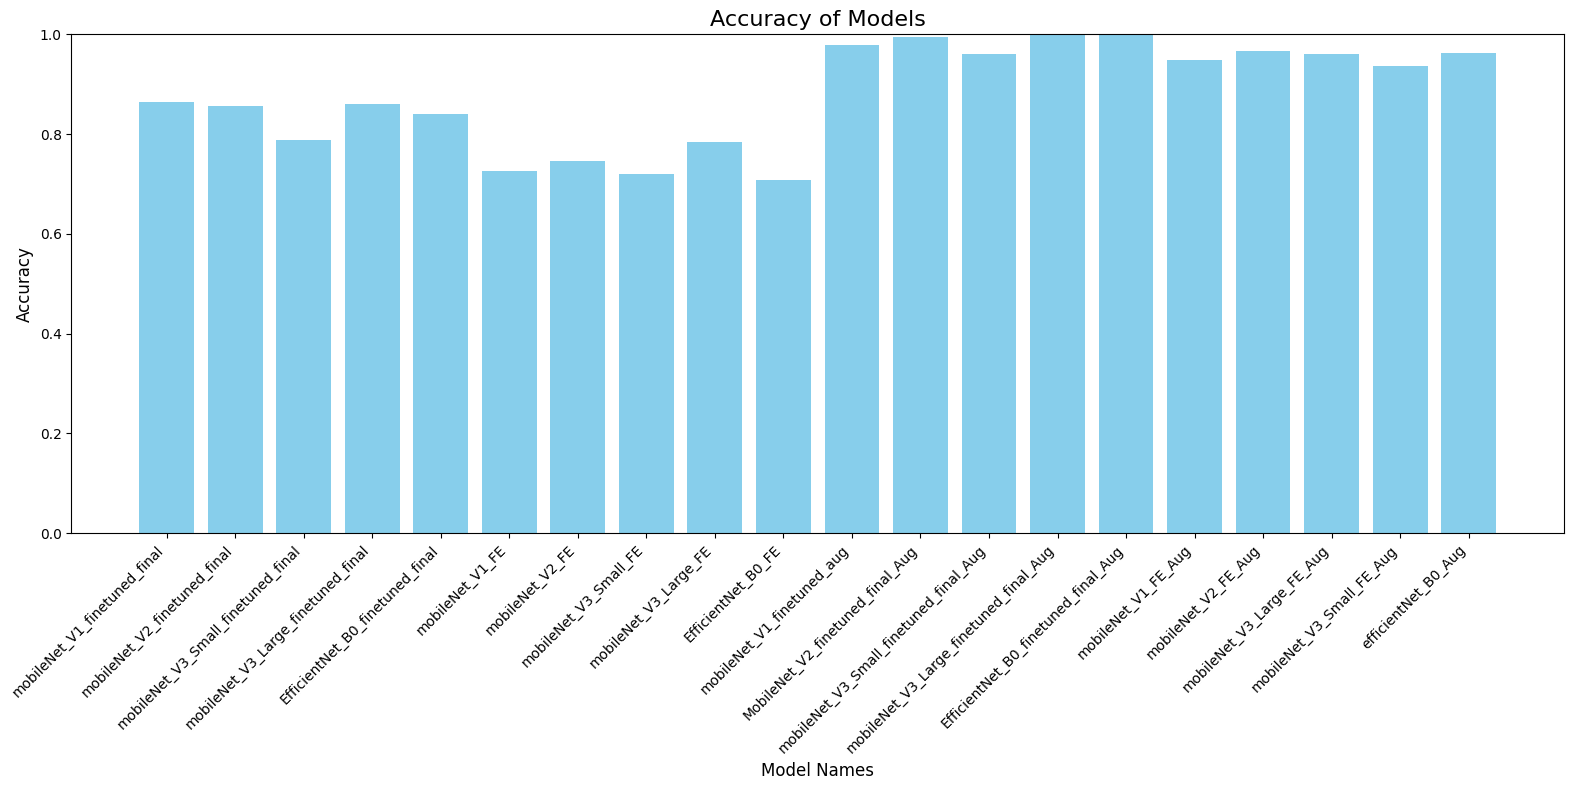

In [14]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Danh sách file checkpoint
checkpoints = [
    'Checkpoint_FT/mobileNet_V1_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V2_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Small_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Large_finetuned_final.keras',
    'Checkpoint_FT/EfficientNet_B0_finetuned_final.keras',
    'Checkpoint_FE/mobileNet_V1_FE.keras',
    'Checkpoint_FE/mobileNet_V2_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Small_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Large_FE.keras',
    'Checkpoint_FE/EfficientNet_B0_FE.keras',
    'Checkpoint_FT_Aug/mobileNet_V1_finetuned_aug.keras',
    'Checkpoint_FT_Aug/MobileNet_V2_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Small_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Large_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/EfficientNet_B0_finetuned_final_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V1_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V2_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Large_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Small_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/efficientNet_B0_Aug.keras'
]

# Đường dẫn dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Hàm đánh giá mô hình chỉ tính độ chính xác
def evaluate_accuracy(checkpoint_files, test_dataset):
    accuracies = {}
    for checkpoint_file in checkpoint_files:
        # Load mô hình
        model_name = os.path.basename(checkpoint_file).replace(".keras", "")
        print(f"Đang đánh giá mô hình: {model_name}")
        model = load_model(checkpoint_file)
        
        # Đánh giá độ chính xác
        _, accuracy = model.evaluate(test_dataset, verbose=0)
        accuracies[model_name] = accuracy
    return accuracies

# Đánh giá độ chính xác của các checkpoint
accuracies = evaluate_accuracy(checkpoints, validation_dataset)

# Tạo biểu đồ
plt.figure(figsize=(16, 8))
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())

plt.bar(model_names, accuracy_values, color='skyblue')
plt.title('Accuracy of Models', fontsize=16)
plt.xlabel('Model Names', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1)  # Đặt giới hạn trục Y từ 0 đến 1 (vì accuracy nằm trong khoảng này)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Đang đánh giá mô hình: mobileNet_V1_finetuned_final
Đang đánh giá mô hình: mobileNet_V2_finetuned_final
Đang đánh giá mô hình: mobileNet_V3_Small_finetuned_final
Đang đánh giá mô hình: mobileNet_V3_Large_finetuned_final
Đang đánh giá mô hình: EfficientNet_B0_finetuned_final
Đang đánh giá mô hình: mobileNet_V1_FE
Đang đánh giá mô hình: mobileNet_V2_FE
Đang đánh giá mô hình: mobileNet_V3_Small_FE
Đang đánh giá mô hình: mobileNet_V3_Large_FE
Đang đánh giá mô hình: EfficientNet_B0_FE
Đang đánh giá mô hình: mobileNet_V1_finetuned_aug
Đang đánh giá mô hình: MobileNet_V2_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V3_Small_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V3_Large_finetuned_final_Aug
Đang đánh giá mô hình: EfficientNet_B0_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V1_FE_Aug
Đang đánh giá mô hình: mobileNet_V2_FE_Aug
Đang đánh giá mô hình: mobileNet_V3_Large_FE_Aug
Đang đánh giá mô

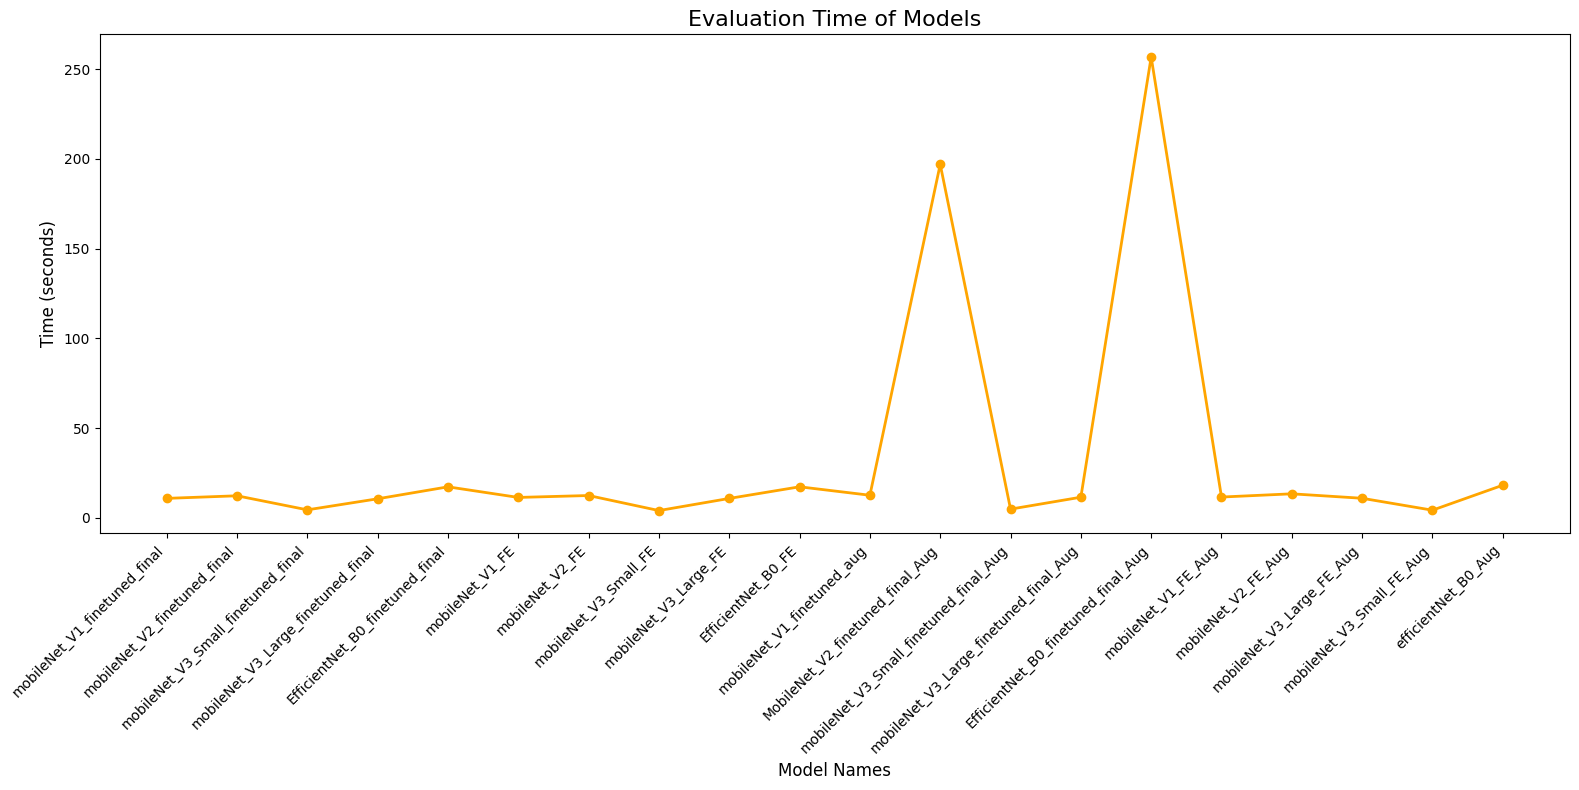

In [15]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import time

# Danh sách file checkpoint
checkpoints = [
    'Checkpoint_FT/mobileNet_V1_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V2_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Small_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Large_finetuned_final.keras',
    'Checkpoint_FT/EfficientNet_B0_finetuned_final.keras',
    'Checkpoint_FE/mobileNet_V1_FE.keras',
    'Checkpoint_FE/mobileNet_V2_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Small_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Large_FE.keras',
    'Checkpoint_FE/EfficientNet_B0_FE.keras',
    'Checkpoint_FT_Aug/mobileNet_V1_finetuned_aug.keras',
    'Checkpoint_FT_Aug/MobileNet_V2_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Small_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Large_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/EfficientNet_B0_finetuned_final_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V1_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V2_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Large_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Small_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/efficientNet_B0_Aug.keras'
]

# Đường dẫn dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Hàm đánh giá thời gian thực thi
def evaluate_time_only(checkpoint_files, test_dataset):
    evaluation_times = {}
    for checkpoint_file in checkpoint_files:
        # Load mô hình
        model_name = os.path.basename(checkpoint_file).replace(".keras", "")
        print(f"Đang đánh giá mô hình: {model_name}")
        
        # Bắt đầu tính thời gian
        start_time = time.time()
        
        model = load_model(checkpoint_file)
        model.evaluate(test_dataset, verbose=0)
        
        # Tính thời gian thực thi
        elapsed_time = time.time() - start_time
        evaluation_times[model_name] = elapsed_time
    return evaluation_times

# Đánh giá thời gian thực thi
evaluation_times = evaluate_time_only(checkpoints, validation_dataset)

# Vẽ biểu đồ đường
plt.figure(figsize=(16, 8))
model_names = list(evaluation_times.keys())
evaluation_time_values = list(evaluation_times.values())

plt.plot(model_names, evaluation_time_values, color='orange', marker='o', linewidth=2)
plt.title('Evaluation Time of Models', fontsize=16)
plt.xlabel('Model Names', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Đang đánh giá mô hình: mobileNet_V1_finetuned_final
Đang đánh giá mô hình: mobileNet_V2_finetuned_final
Đang đánh giá mô hình: mobileNet_V3_Small_finetuned_final
Đang đánh giá mô hình: mobileNet_V3_Large_finetuned_final
Đang đánh giá mô hình: EfficientNet_B0_finetuned_final
Đang đánh giá mô hình: mobileNet_V1_FE
Đang đánh giá mô hình: mobileNet_V2_FE
Đang đánh giá mô hình: mobileNet_V3_Small_FE
Đang đánh giá mô hình: mobileNet_V3_Large_FE
Đang đánh giá mô hình: EfficientNet_B0_FE
Đang đánh giá mô hình: mobileNet_V1_finetuned_aug
Đang đánh giá mô hình: MobileNet_V2_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V3_Small_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V3_Large_finetuned_final_Aug
Đang đánh giá mô hình: EfficientNet_B0_finetuned_final_Aug
Đang đánh giá mô hình: mobileNet_V1_FE_Aug
Đang đánh giá mô hình: mobileNet_V2_FE_Aug
Đang đánh giá mô hình: mobileNet_V3_Large_FE_Aug
Đang đánh giá mô

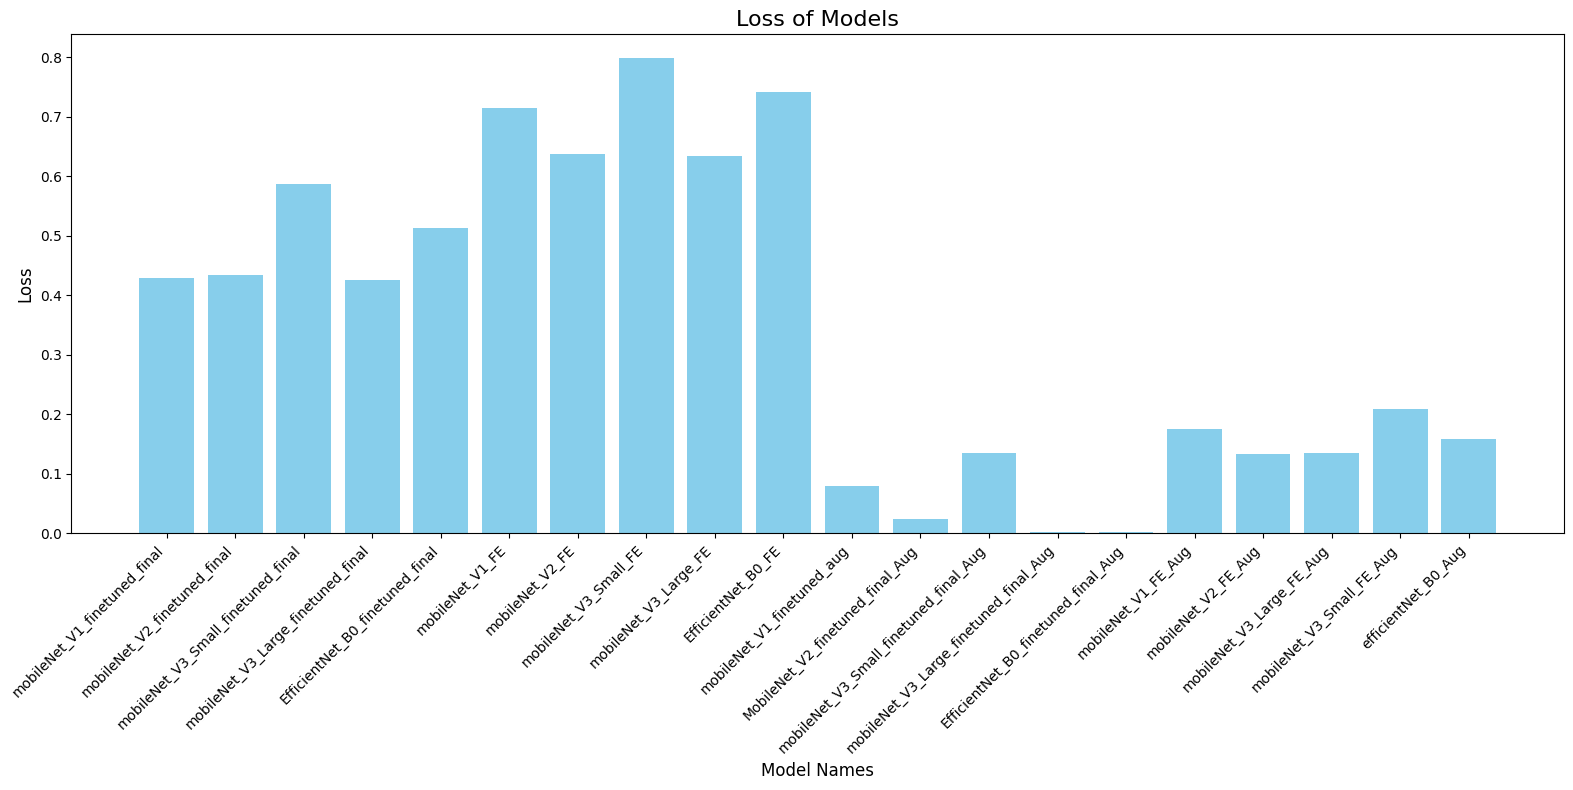

In [16]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Danh sách file checkpoint
checkpoints = [
    'Checkpoint_FT/mobileNet_V1_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V2_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Small_finetuned_final.keras',
    'Checkpoint_FT/mobileNet_V3_Large_finetuned_final.keras',
    'Checkpoint_FT/EfficientNet_B0_finetuned_final.keras',
    'Checkpoint_FE/mobileNet_V1_FE.keras',
    'Checkpoint_FE/mobileNet_V2_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Small_FE.keras',
    'Checkpoint_FE/mobileNet_V3_Large_FE.keras',
    'Checkpoint_FE/EfficientNet_B0_FE.keras',
    'Checkpoint_FT_Aug/mobileNet_V1_finetuned_aug.keras',
    'Checkpoint_FT_Aug/MobileNet_V2_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Small_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/mobileNet_V3_Large_finetuned_final_Aug.keras',
    'Checkpoint_FT_Aug/EfficientNet_B0_finetuned_final_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V1_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V2_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Large_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/mobileNet_V3_Small_FE_Aug.keras',
    'D:/AnacondaPython/NCKH/DanhGiaMoHinh/Checkpoit_FE_Aug/efficientNet_B0_Aug.keras'
]

# Đường dẫn dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Hàm đánh giá loss cho các mô hình
def evaluate_loss(checkpoint_files, test_dataset):
    losses = {}
    for checkpoint_file in checkpoint_files:
        # Load mô hình
        model_name = os.path.basename(checkpoint_file).replace(".keras", "")
        print(f"Đang đánh giá mô hình: {model_name}")
        
        model = load_model(checkpoint_file)
        
        # Đánh giá loss
        loss, _ = model.evaluate(test_dataset, verbose=0)
        losses[model_name] = loss
    return losses

# Đánh giá loss của các mô hình
losses = evaluate_loss(checkpoints, validation_dataset)

# Vẽ biểu đồ cột cho loss
plt.figure(figsize=(16, 8))
model_names = list(losses.keys())
loss_values = list(losses.values())

plt.bar(model_names, loss_values, color='skyblue')
plt.title('Loss of Models', fontsize=16)
plt.xlabel('Model Names', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()
